# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
SCIPER1 = 291832
SCIPER2 = 291622

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [8]:
!pip install keras

In [9]:
!git clone https://LianCHEN@bitbucket.org/LianCHEN/housenumbers.git
!ls

fatal: destination path 'housenumbers' already exists and is not an empty directory.
datalab  housenumbers


In [10]:
!ls

datalab  housenumbers


In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling2D,MaxPooling1D, Dropout, Flatten, Activation
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization
from keras import regularizers

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
#np.random.seed(hash(student1 + student2) % 2**32)
#changed according to email
np.random.seed(SCIPER1 + SCIPER2)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [37]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')


x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

In [34]:

print(x_train_all.shape)

(73257, 256)


### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [32]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

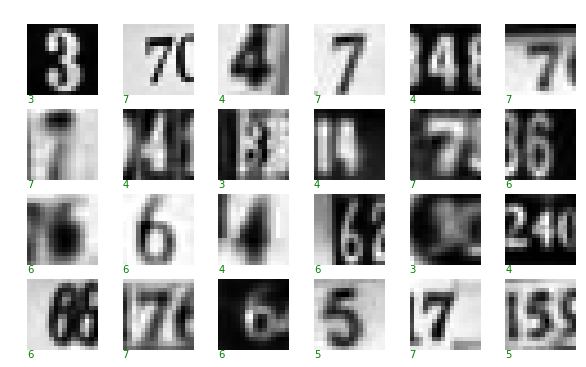

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [40]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

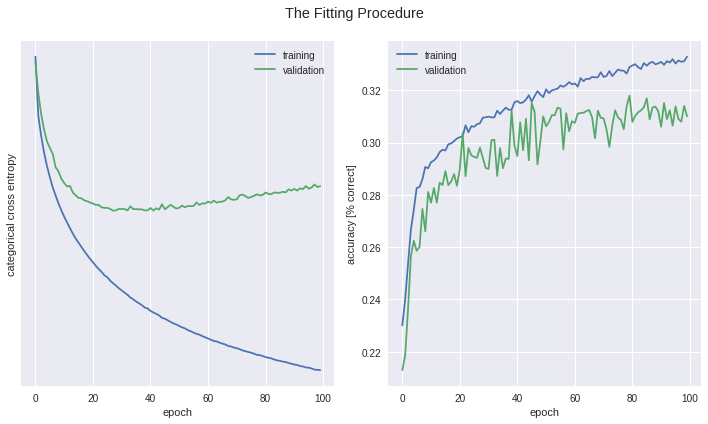

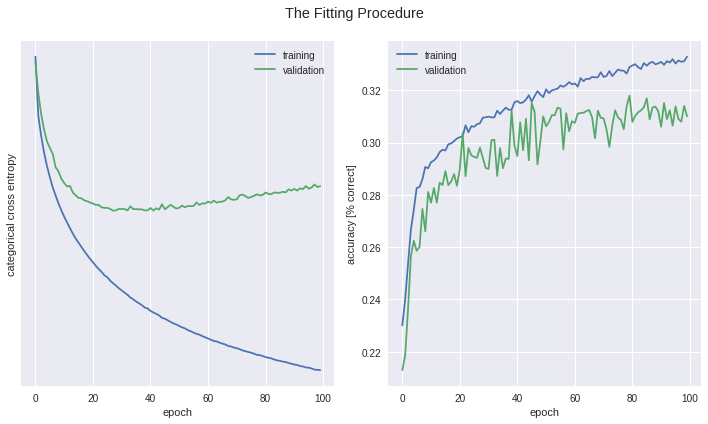

In [35]:
# build model 
model1 = Sequential()
input_number = x_train.shape[1]
# add softmax activation for the output layer
model1.add(Dense(5, input_dim=256, activation='softmax'))
# Use the categorical_crossentropy loss and the accuracy metric to the metrics
model1.compile(loss='categorical_crossentropy', 
                optimizer='sgd',
                metrics=['accuracy'])
history = model1.fit(x_train, y_train, epochs=100, batch_size=128,validation_data = (x_test, y_test),verbose = 0)
#model1.summary()
plot_history(history, 'The Fitting Procedure')

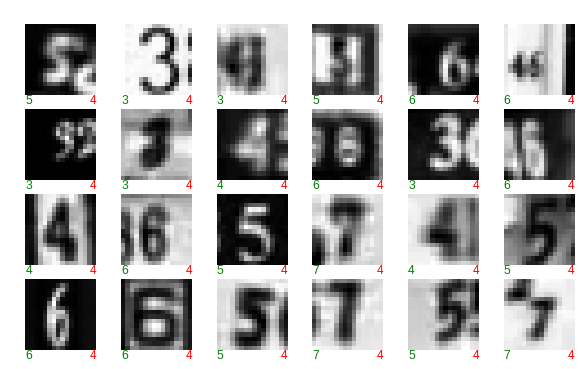

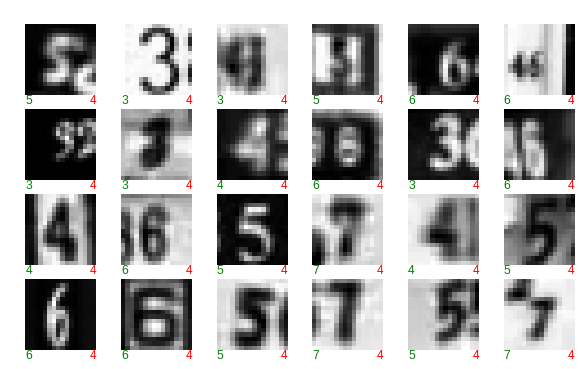

In [16]:
# predict based on fitted model
yhat_test = model1.predict(x_test).round()
#find the indices of error prediction
error_indices = [index for (index,value) in enumerate(y_test) if not (value == yhat_test[index]).all()]
#plot the examples are classfied wrongly
plot_some_samples(x_test, y_test,yhat_test, select_from =error_indices,label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [17]:
# build required model. The default learning rate is 0.1
def build_model_with_sgd(learning_rate = 0.1):
    model = Sequential()
    input_number = x_train.shape[1]
    #add one hidden layter with 64 units and the 'relu' activation
    model.add(Dense(64, input_dim=256, activation='relu',name = 'H1'))
    model.add(Dense(5, activation='softmax',name = 'Y'))
    sgd = SGD(lr = learning_rate)
    model.compile(loss='categorical_crossentropy', 
                    optimizer= sgd,
                    metrics=['accuracy'])
    print('\n\n model with learning rate:',learning_rate)
    #use summary() to inspect the model
    model.summary()
    return model
build_model_with_sgd(0.01)



 model with learning rate: 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________




 model with learning rate: 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________

 
 model with learning rate: 0.01


 model with learning rate: 0.02
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_______________________________

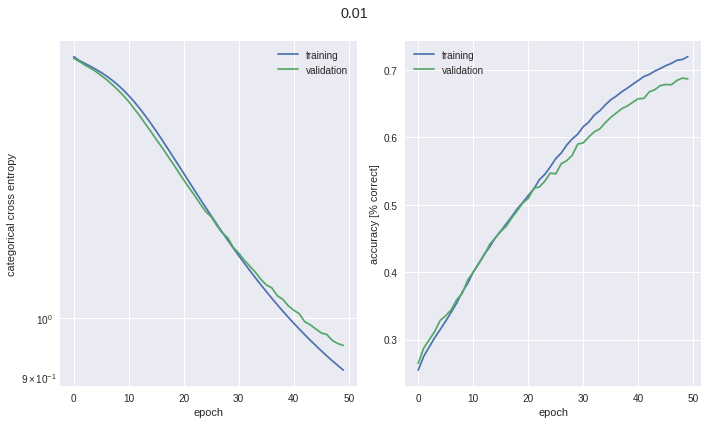

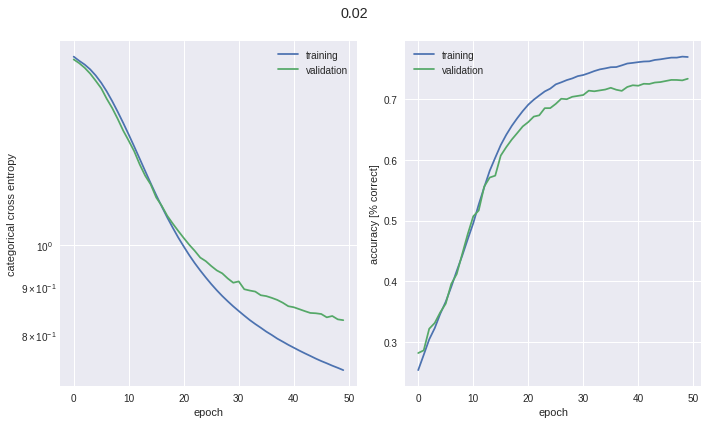

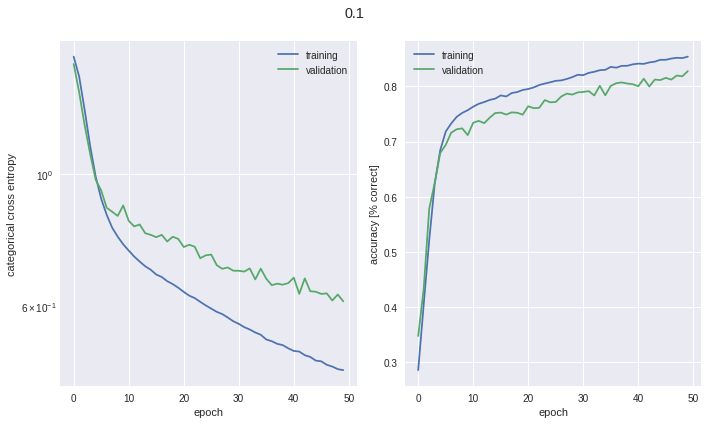

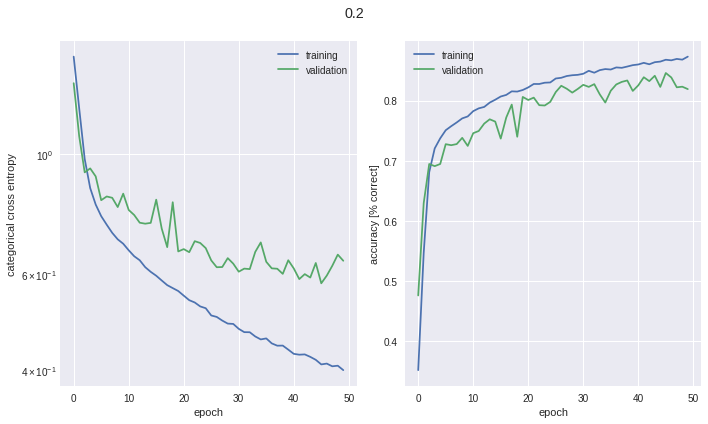

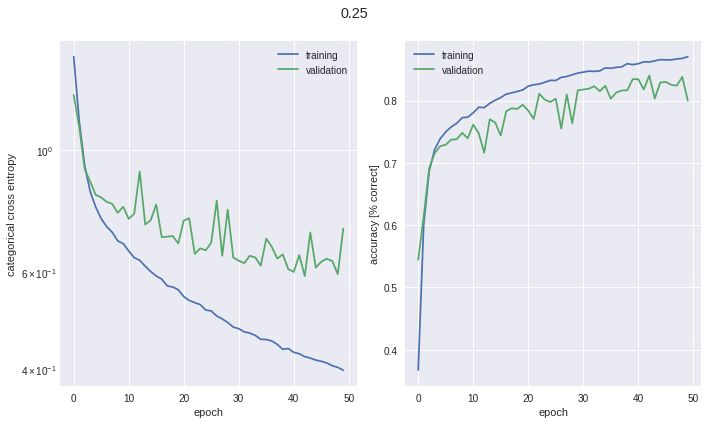

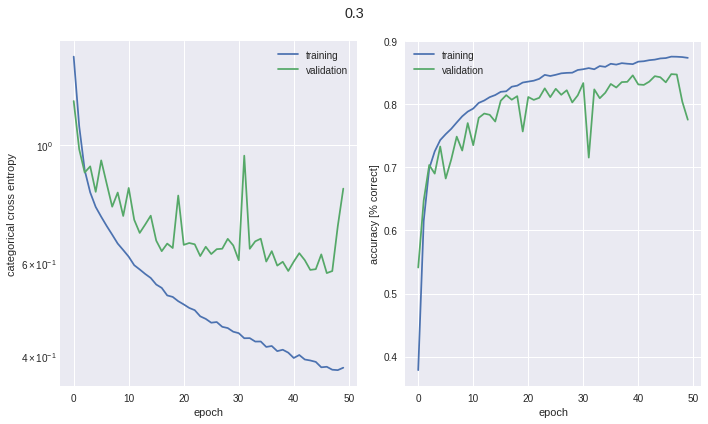

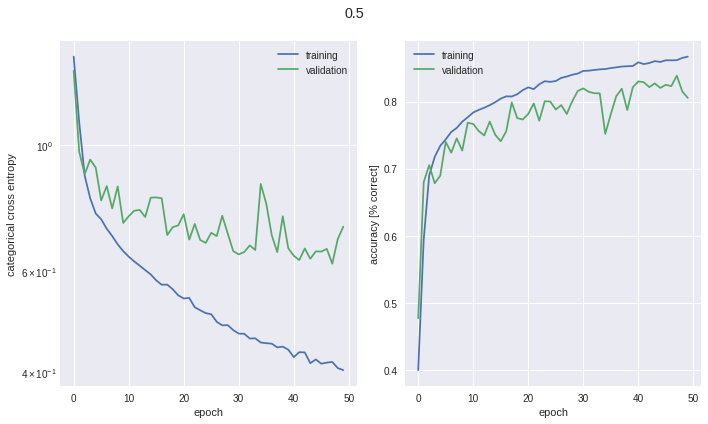

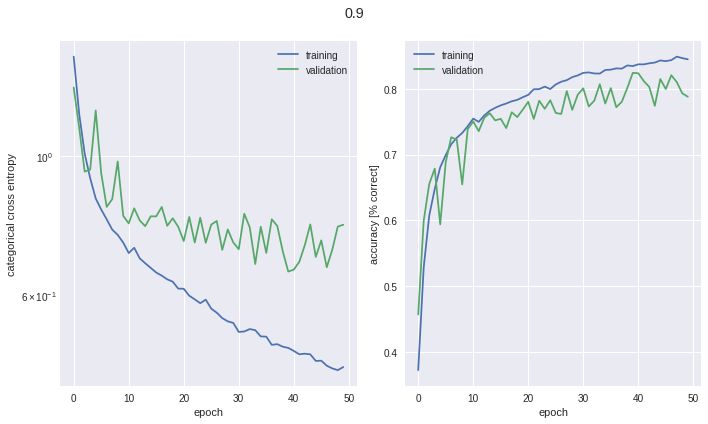

In [27]:
# train model with different learning rates
def train_models_with_diff_learning_rates(lrs = []):
    logs = {'loss':[],'acc':[], 'val_loss': [], 'val_acc':[]}
    best_acc = 0.
    best_model_index = 0
    count = 0
    # if the list of learning rate is not specified, just train one model with default learning rate
    if len(lrs) == 0:
        model2 = build_model_with_sgd()
        log.append(model2.fit(x_train, y_train, epochs=50, batch_size=128,validation_data = (x_test, y_test),verbose = 1))
    # train models with provided learning rate
    for learning_rate in lrs:
        model = build_model_with_sgd(learning_rate)
        print('\n \n model with learning rate:',learning_rate)
        history = model.fit(x_train, y_train, epochs=50,batch_size=128,validation_data = (x_test, y_test),verbose = 0)
        plot_history(history, str(learning_rate))
        history = history.history
        #choose the so-far best model
        if history['val_acc'][-1] > best_acc:
            best_acc = history['val_acc'][-1]
            bestmodel = model
            best_model_index = count
        count += 1
        # record loss, acc, val_loss, val_acc for all models.
        logs['loss'].append(history['loss']) 
        logs['acc'].append(history['acc']) 
        logs['val_loss'].append(history['val_loss']) 
        logs['val_acc'].append(history['val_acc']) 
    #return the training logs, best model and the index of best model in learning rate lisr
    return logs, bestmodel,best_model_index
logs, best_model,best_model_index = train_models_with_diff_learning_rates([0.01,0.02, 0.1, 0.2,0.25,0.3, 0.5, 0.9])
print(best_model_index)

In [0]:
def plotPerf(logs):
    plt.figure(figsize=(12,8))
    plt.plot(np.array(logs['loss']).T, '--', c='red')
    plt.plot(np.array(logs['val_loss']).T, c='blue')
    plt.title('%.4f ($\pm$ %.4f)' % (np.mean(logs['val_loss'][-1]), 2*np.std(logs['val_loss'][-1])))
    
    plt.figure(figsize=(12,8))
    plt.plot(np.array(logs['acc']).T, '--', c='red')
    plt.plot(np.array(logs['val_acc']).T, c='blue')
    plt.title('%.4f ($\pm$ %.4f)' % (np.mean(logs['val_acc'][-1]), 2*np.std(logs['val_acc'][-1])))
    

#plotPerf(logs)



In [21]:
#build the model with 'adam' optimizer
model_adam = Sequential()
input_number = x_train.shape[1]
model_adam.add(Dense(64, input_dim=input_number, activation='relu',name = 'H1'))
model_adam.add(Dense(5, activation='softmax',name = 'Y'))
model_adam.compile(loss='categorical_crossentropy', 
                optimizer= 'Adam',
                metrics=['accuracy'])
model_adam.summary()
adam_log = model_adam.fit(x_train, y_train, epochs=50, batch_size=128,validation_data = (x_test, y_test),verbose = 1).history

#build the model with 'sgd' optimizer with best learning rate we found in last question
model_sgd = Sequential()
input_number = x_train.shape[1]
model_sgd.add(Dense(64, input_dim=256, activation='relu',name = 'H1'))
model_sgd.add(Dense(5, activation='softmax',name = 'Y'))
sgd = SGD(lr = 0.25)
model_sgd.compile(loss='categorical_crossentropy', 
                optimizer= sgd,
                metrics=['accuracy'])
sgd_log = model_sgd.fit(x_train, y_train, epochs=50, batch_size=128,validation_data = (x_test, y_test),verbose = 1).history



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Train on 34159 samples, validate on 11785 samples
Epoch 1/50
34159/34159 [==============================] - 2s 56us/step - loss: 1.4696 - acc: 0.4112 - val_loss: 1.2772 - val_acc: 0.5244
Epoch 2/50
34159/34159 [==============================] - 2s 53us/step - loss: 1.1191 - acc: 0.6363 - val_loss: 1.0074 - val_acc: 0.6798
Epoch 3/50
34159/34159 [==============================] - 2s 53us/step - loss: 0.9287 - acc: 0.7145 - val_loss: 0.9287 - val_acc: 0.7016
Epoch 4/50
15232/34159 [============>.................] - ETA: 0s - loss:

28032/34159 [=======================>......] - ETA: 0s - loss: 1.1268 - acc: 0.596334159/34159 [==============================] - 2s 45us/step - loss: 1.1037 - acc: 0.6082 - val_loss: 1.0632 - val_acc: 0.6111
Epoch 3/50
34159/34159 [==============================] - 2s 44us/step - loss: 0.9264 - acc: 0.6896 - val_loss: 0.9293 - val_acc: 0.6812
Epoch 4/50
34159/34159 [==============================] - 2s 44us/step - loss: 0.8322 - acc: 0.7241 - val_loss: 0.8744 - val_acc: 0.7158
Epoch 5/50
34159/34159 [==============================] - 2s 44us/step - loss: 0.7824 - acc: 0.7390 - val_loss: 0.8335 - val_acc: 0.7280
Epoch 6/50
34159/34159 [==============================] - 1s 43us/step - loss: 0.7483 - acc: 0.7503 - val_loss: 0.8214 - val_acc: 0.7347
Epoch 7/50
34159/34159 [==============================] - 1s 44us/step - loss: 0.7215 - acc: 0.7572 - val_loss: 0.8129 - val_acc: 0.7351
Epoch 8/50
34159/34159 [==============================] - 2s 44us/step - loss: 0.6985 - acc: 0.7666 - val_

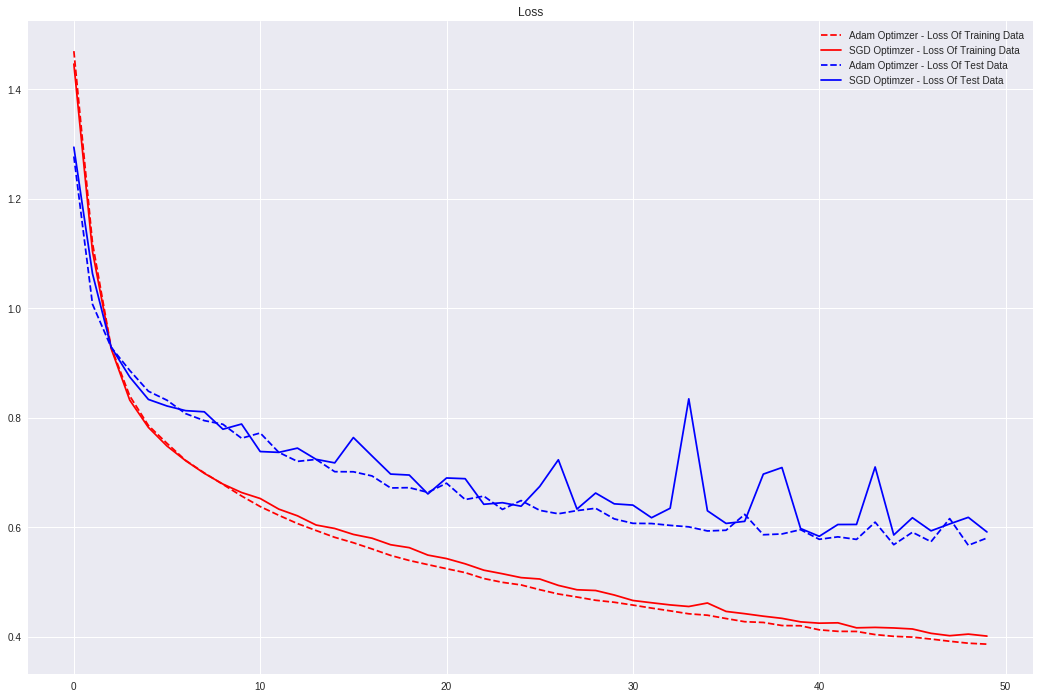

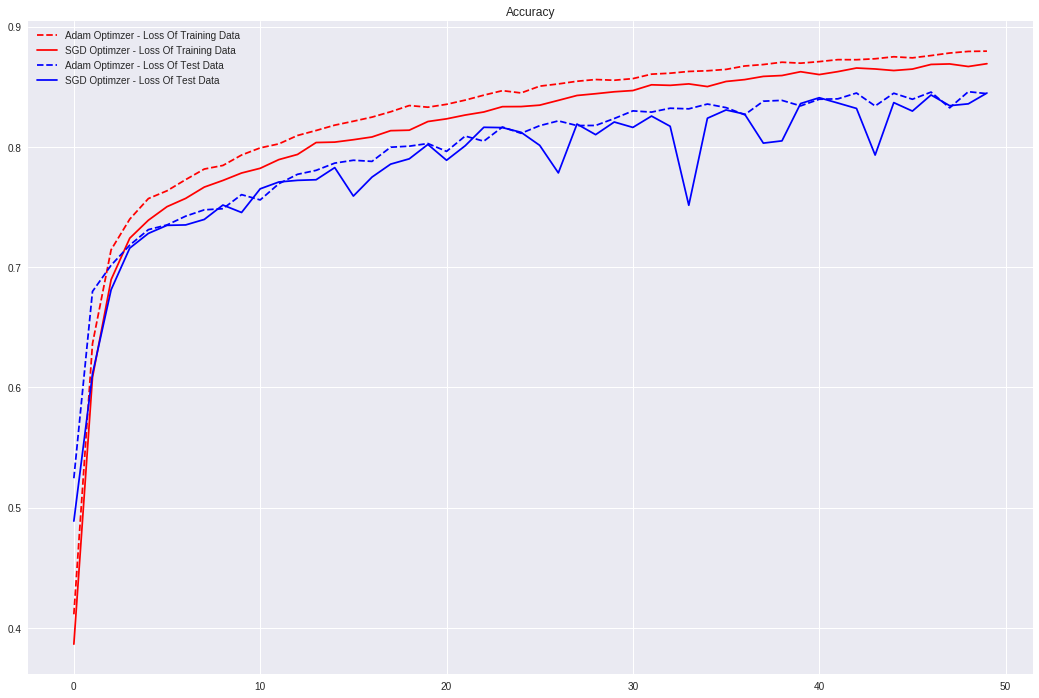

In [22]:
# plot the learning curve
plt.figure(figsize=(18,12))
# red line are curves for training data
# blue line are curves for test data
plt.plot(adam_log['loss'], '--', c='red',label = 'Adam Optimzer - Loss Of Training Data')
plt.plot(sgd_log['loss'], c='red',label = 'SGD Optimzer - Loss Of Training Data')
plt.plot(adam_log['val_loss'], '--', c='blue',label = 'Adam Optimzer - Loss Of Test Data')
plt.plot(sgd_log['val_loss'], c='blue',label = 'SGD Optimzer - Loss Of Test Data')
plt.title('Loss' )
plt.legend()
    
plt.figure(figsize=(18,12))
plt.plot(adam_log['acc'], '--', c='red',label = 'Adam Optimzer - Loss Of Training Data')
plt.plot(sgd_log['acc'], c='red',label = 'SGD Optimzer - Loss Of Training Data')
plt.plot(adam_log['val_acc'], '--', c='blue',label = 'Adam Optimzer - Loss Of Test Data')
plt.plot(sgd_log['val_acc'], c='blue',label = 'SGD Optimzer - Loss Of Test Data')
plt.title('Accuracy' )

plt.legend()

In [0]:
# predict and plot incorrectly-plotted samples
yhat_test = model_sgd.predict(x_test).round()
error_indices = [index for (index,value) in enumerate(y_test) if not (value == yhat_test[index]).all()]
plot_some_samples(x_test, y_test,yhat_test, select_from =error_indices,label_mapping = subset_of_classes)

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) The graph shows a lot of fluctuation, and the gradient descent may not be converged.

B) The speed of gradient descent is slow.

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


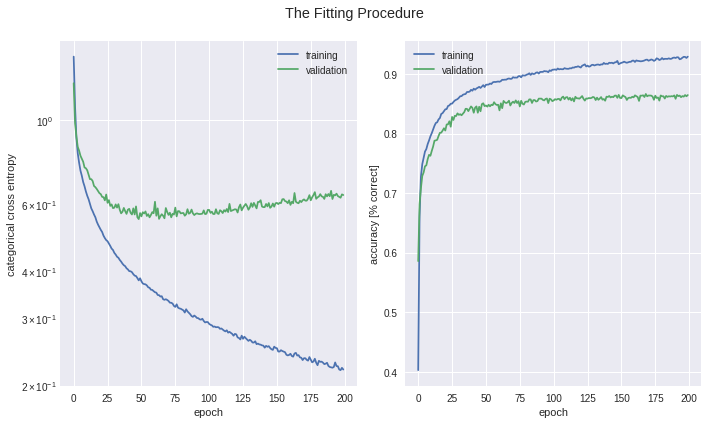

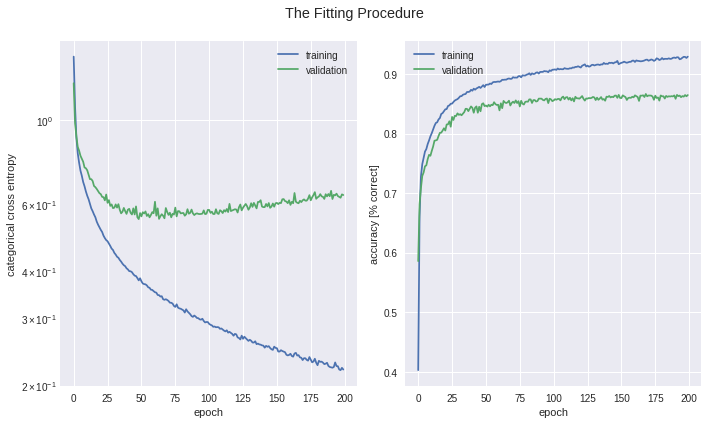

In [31]:
# plot the learning curves of a fit with Adam and sufficiently many epochs 
model_adam2 = Sequential()
input_number = x_train.shape[1]
model_adam2.add(Dense(64, input_dim=input_number, activation='relu',name = 'H1'))
model_adam2.add(Dense(5, activation='softmax',name = 'Y'))
model_adam2.compile(loss='categorical_crossentropy', 
                optimizer= 'Adam',
                metrics=['accuracy'])
model_adam2.summary()
history = model_adam2.fit(x_train, y_train, epochs = 200 , batch_size=128,validation_data = (x_test, y_test),verbose = 0)
plot_history(history, 'The Fitting Procedure')

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 50

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**:

(a)With overfitting, the training accuracy is very high, while training loss is very low.

(b)But the validation loss starts to increase, and validation accuracy is lower comoared to training.




## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [0]:
def plotBoxes(counter, data, title):

  fig, ax1 = plt.subplots(figsize=(14, 10))
  fig.canvas.set_window_title(title)
  plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

  bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
  plt.setp(bp['boxes'], color='black')
  plt.setp(bp['whiskers'], color='black')
  plt.setp(bp['fliers'], color='red', marker='+')

  # Add a horizontal grid to the plot, but make it very light in color
  # so we can use it for reading data values but not be distracting
  ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                 alpha=0.5)

  # Hide these grid behind plot objects
  ax1.set_axisbelow(True)
  ax1.set_title('final ' + title + ' versus the number of hidden neurons')
  ax1.set_xlabel('number of neurons')
  ax1.set_ylabel(title)

  # Now fill the boxes with desired colors
  boxColors = ['red', 'royalblue']
  numBoxes = counter
  #medians = list(range(numBoxes))
  for i in range(numBoxes):
      box = bp['boxes'][i]
      boxX = []
      boxY = []
      for j in range(5):
          boxX.append(box.get_xdata()[j])
          boxY.append(box.get_ydata()[j])
      boxCoords = list(zip(boxX, boxY))
      # Alternate between Dark Khaki and Royal Blue
      k = i % 2
      boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
      ax1.add_patch(boxPolygon)
      # Now draw the median lines back over what we just filled in
#       med = bp['medians'][i]
#       medianX = []
#       medianY = []
#       for j in range(2):
#           medianX.append(med.get_xdata()[j])
#           medianY.append(med.get_ydata()[j])
#           plt.plot(medianX, medianY, 'k')
#           medians[i] = medianY[0]
      # Finally, overplot the sample averages, with horizontal alignment
      # in the center of each box
#       plt.plot([np.average(med.get_xdata())], [np.average(data[i])],
#                color='w', marker='*', markeredgecolor='k')

  # Set the axes ranges and axes labels
  xrange = range(10, 1100, 100)
  ax1.set_xlim(0.5, numBoxes + 0.5)
#   top = 1
#   bottom = 0
#   ax1.set_ylim(bottom, top)
  xtickNames = plt.setp(ax1, xticklabels=xrange)
  plt.setp(xtickNames, fontsize=8)

#   # Due to the Y-axis scale being different across samples, it can be
#   # hard to compare differences in medians across the samples. Add upper
#   # X-axis tick labels with the sample medians to aid in comparison
#   # (just use two decimal places of precision)
#   pos = np.arange(numBoxes) + 1
#   upperLabels = [str(np.round(s, 2)) for s in medians]
#   weights = ['bold', 'semibold']
#   for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
#       k = tick % 2
#       ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
#                horizontalalignment='center', size='x-small', weight=weights[k],
#                color=boxColors[k])

  plt.show()

hidden layer size: 10 
the 1-th initial conditionearly stopping: 0 

hidden layer size: 10 
the 2-th initial conditionearly stopping: 0 

hidden layer size: 10 
the 3-th initial conditionearly stopping: 0 

hidden layer size: 10 
the 4-th initial conditionearly stopping: 0 

hidden layer size: 10 
the 5-th initial conditionearly stopping: 0 

hidden layer size: 10 
the 6-th initial conditionearly stopping: 0 

hidden layer size: 10 
the 7-th initial conditionearly stopping: 0 

hidden layer size: 10 
the 8-th initial conditionearly stopping: 0 

hidden layer size: 110 
the 1-th initial conditionearly stopping: 0 

hidden layer size: 110 
the 2-th initial conditionearly stopping: 0 

hidden layer size: 110 
the 3-th initial conditionearly stopping: 0 

hidden layer size: 110 
the 4-th initial conditionearly stopping: 0 

hidden layer size: 110 
the 5-th initial conditionearly stopping: 0 

hidden layer size: 110 
the 6-th initial conditionearly stopping: 0 

hidden layer size: 110 
the 

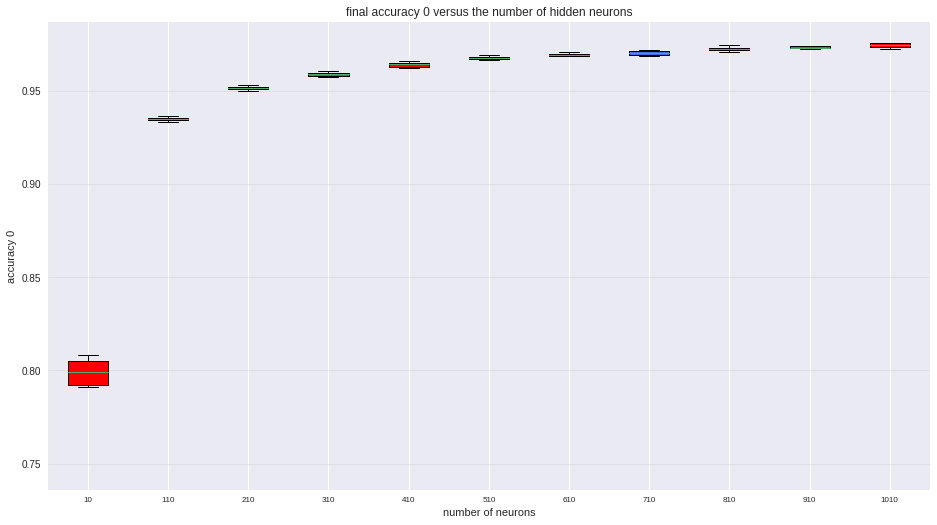

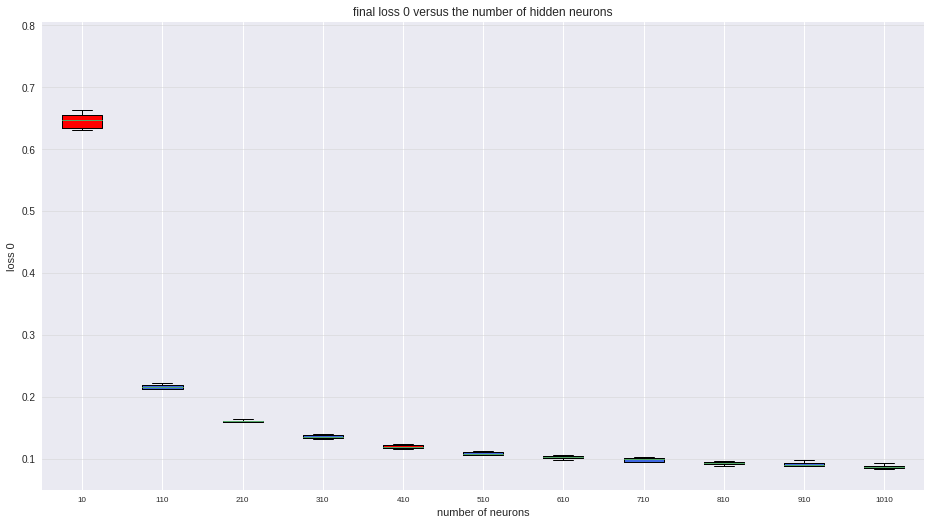

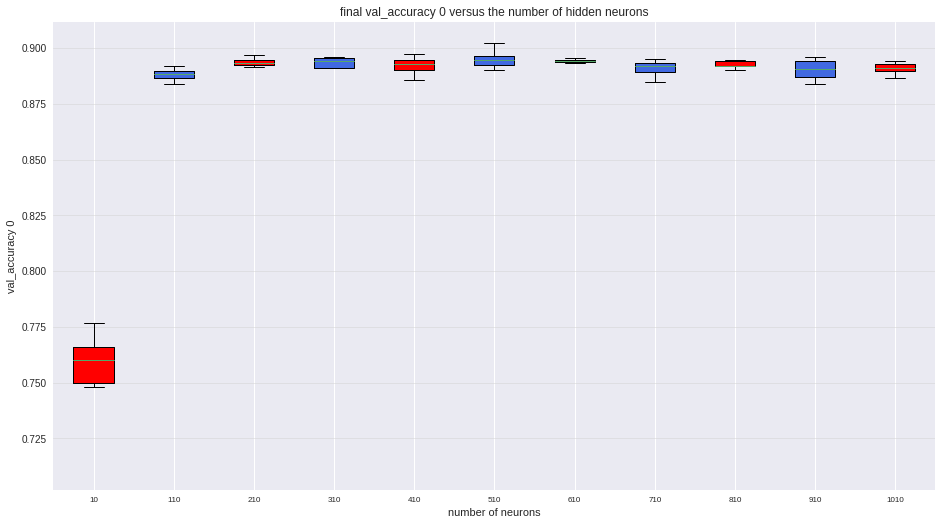

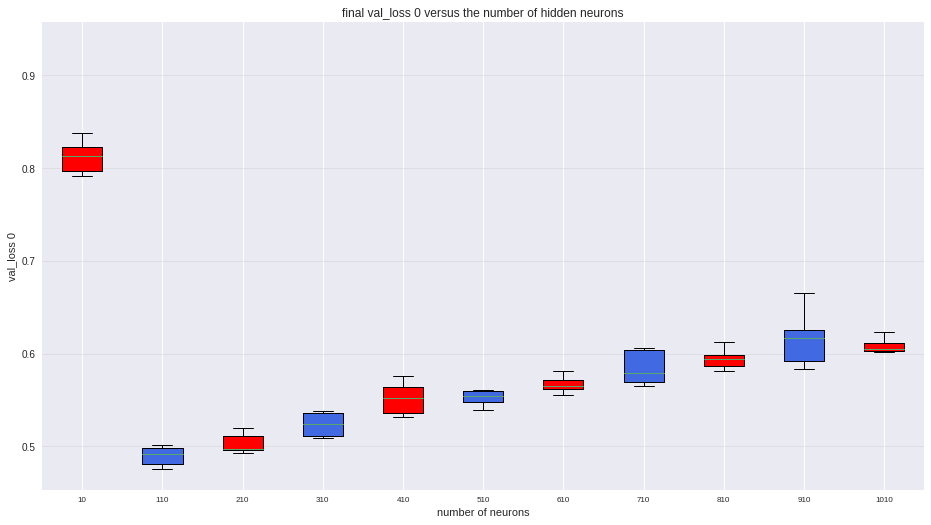

hidden layer size: 10 
the 1-th initial conditionearly stopping: 1 

hidden layer size: 10 
the 2-th initial conditionearly stopping: 1 

hidden layer size: 10 
the 3-th initial conditionearly stopping: 1 

hidden layer size: 10 
the 4-th initial conditionearly stopping: 1 

hidden layer size: 10 
the 5-th initial conditionearly stopping: 1 

hidden layer size: 10 
the 6-th initial conditionearly stopping: 1 

hidden layer size: 10 
the 7-th initial conditionearly stopping: 1 

hidden layer size: 10 
the 8-th initial conditionearly stopping: 1 

hidden layer size: 110 
the 1-th initial conditionearly stopping: 1 

hidden layer size: 110 
the 2-th initial conditionearly stopping: 1 

hidden layer size: 110 
the 3-th initial conditionearly stopping: 1 

hidden layer size: 110 
the 4-th initial conditionearly stopping: 1 

hidden layer size: 110 
the 5-th initial conditionearly stopping: 1 

hidden layer size: 110 
the 6-th initial conditionearly stopping: 1 

hidden layer size: 110 
the 

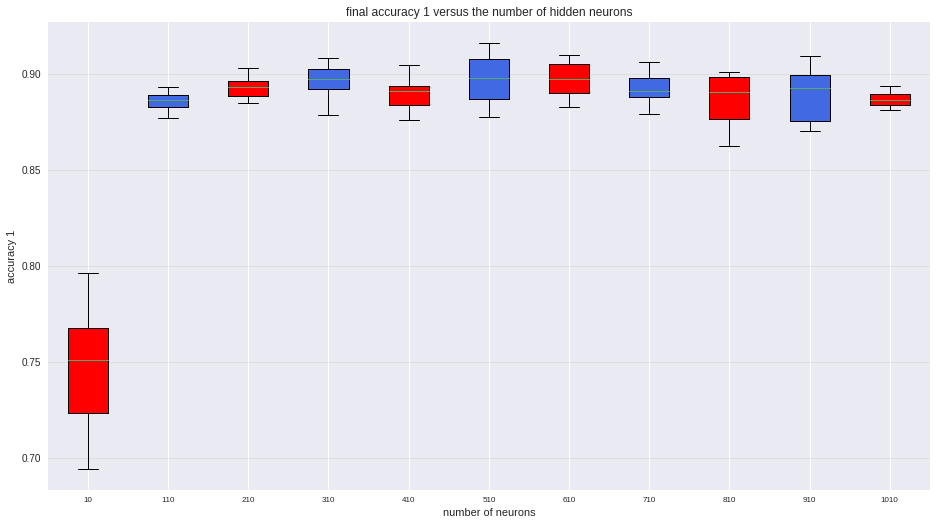

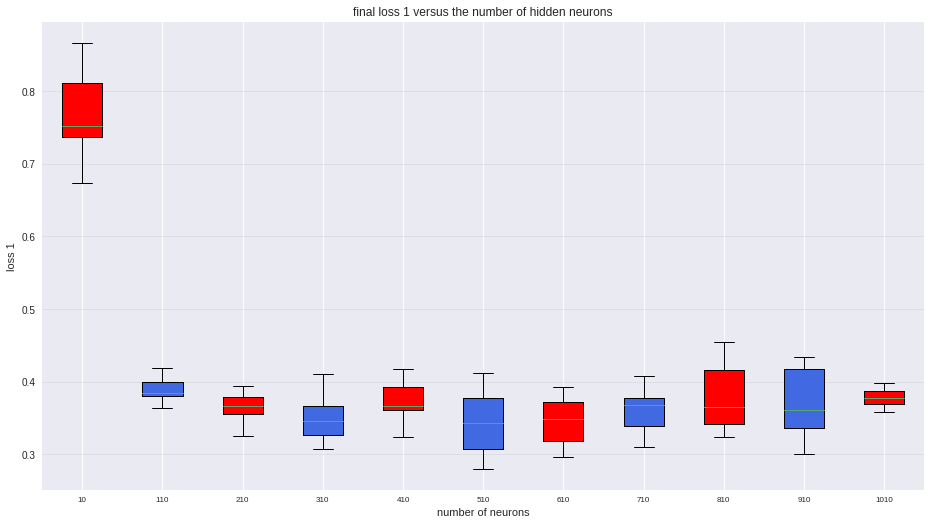

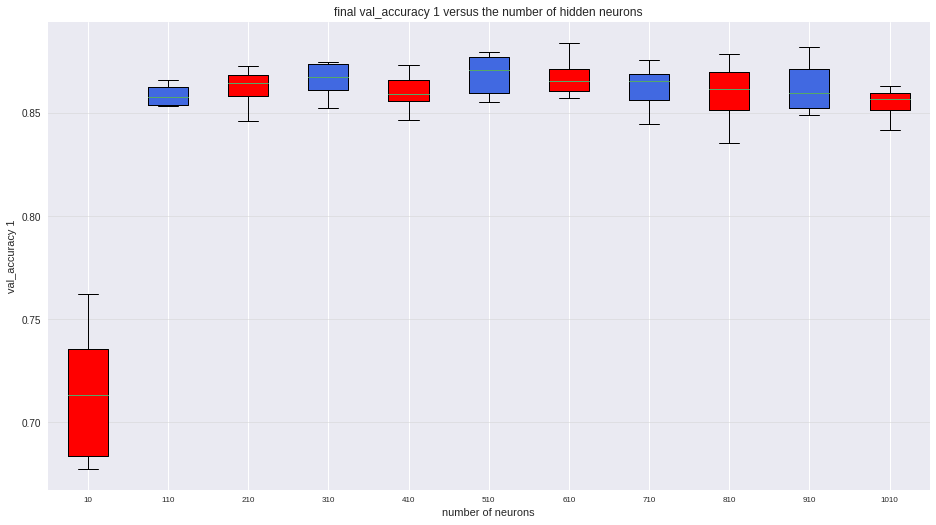

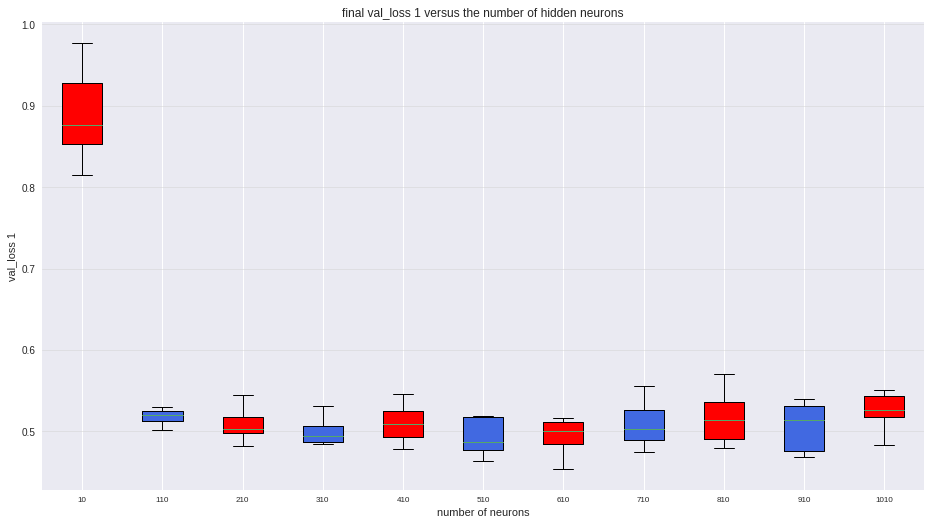

In [13]:
for flag in range(0, 2, 1):
  totalacc=[]
  totalloss=[]
  totalvalacc=[]
  totalvalloss=[]
  counter = 0
  for i in range(10, 1100, 100):
    acc = []
    loss = []
    val_acc = []
    val_loss = []
    for j in range(1,9,1):
      print("hidden layer size: "+ str(i) +" \n" + "the " + str(j) + "-th initial condition" + "early stopping: " + str(flag)+" \n")
      model = Sequential()
      model.add(Dense(i, input_dim=256, activation = 'relu', name='hidden'))
      model.add(Dense(5, activation='softmax', name='result'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      #early stopping or not
      if(flag==0):     
        history = model.fit(x_train, y_train, batch_size=128, epochs=90, verbose=0, validation_data=(x_test, y_test)).history
      else:
        earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')
        history = model.fit(x_train, y_train, batch_size=128, epochs=90, verbose=0, callbacks=[earlyStopping], shuffle=True, validation_data=(x_test, y_test)).history
            
      acc.append(history['acc'][-1])
      loss.append(history['loss'][-1])        
      val_acc.append(history['val_acc'][-1])
      val_loss.append(history['val_loss'][-1])

    counter+=1

    totalacc.append(acc)
    totalloss.append(loss)
    totalvalacc.append(val_acc)
    totalvalloss.append(val_loss)

  plotBoxes(counter, totalacc, 'accuracy '+str(flag))
  plotBoxes(counter, totalloss, 'loss '+str(flag))
  plotBoxes(counter, totalvalacc, 'val_accuracy '+str(flag))
  plotBoxes(counter, totalvalloss, 'val_loss '+str(flag))





## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [57]:

model = Sequential()
input_number = x_train.shape[1]
model.add(Dense(100, input_dim=256, activation='relu',name = 'H1'))
model.add(Dense(5, activation='softmax',name = 'Y'))
adam = Adam(lr = 0.25)
model.compile(loss='categorical_crossentropy', 
                optimizer= adam,
                metrics=['accuracy'])
print('\n\n model with learning rate:',0.25)
model.summary()

# use to build model with 2 layer

def build_2_layer_model():
  model = Sequential()
  input_number = x_train.shape[1]
  model.add(Dense(77, input_dim=256, activation='relu',name = 'H1'))
  model.add(Dense(77, activation='relu',name = 'H2'))
  model.add(Dense(5, activation='softmax',name = 'Y'))
  model.compile(loss='categorical_crossentropy', 
                  optimizer= 'adam',
                  metrics=['accuracy'])
  model.summary()
  return model

# use to build model with 3 layer
def build_3_layer_model():
  input_number = x_train.shape[1]
  model = Sequential()
  model.add(Dense(66, input_dim=256, activation='relu',name = 'H1'))
  model.add(Dense(66, activation='relu',name = 'H2'))
  model.add(Dense(66, activation='relu',name = 'H3'))
  model.add(Dense(5, activation='softmax',name = 'Y'))
  model.compile(loss='categorical_crossentropy', 
                  optimizer= 'adam',
                  metrics=['accuracy'])
  model.summary()
  return model

# use to build model with 4 layer
def build_4_layer_model():
  model = Sequential()
  input_number = x_train.shape[1]
  model.add(Dense(59, input_dim=256, activation='relu',name = 'H1'))
  model.add(Dense(59, activation='relu',name = 'H2'))
  model.add(Dense(60, activation='relu',name = 'H3'))
  model.add(Dense(59, activation='relu',name = 'H4'))
  model.add(Dense(5, activation='softmax',name = 'Y'))
  model.compile(loss='categorical_crossentropy', 
                  optimizer= 'adam',
                  metrics=['accuracy'])
  model.summary()
  return model


build_2_layer_model()
build_3_layer_model()
build_4_layer_model()




 model with learning rate: 0.25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 100)               25700     
_________________________________________________________________
Y (Dense)                    (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 77)                19789     
_________________________________________________________________
H2 (Dense)                   (None, 77)                6006      
_________________________________________________________________
Y (Dense)                    (None, 5)                 390       
Total params: 26,185
Trainable params:

In [0]:
model_list={
    2: build_2_layer_model,
    3: build_3_layer_model,
    4: build_4_layer_model
}

def train_models_with_diff_conditions(layer = 2, model_number = 10):
    logs = {'loss':[],'acc':[], 'val_loss': [], 'val_acc':[]}
    best_acc = 0.
    best_model_index = 0
    count = 0
    # train model_number of the n-layer models 
    while (count < model_number):
        model = model_list[layer]()
        history = model.fit(x_train, y_train, epochs=90,batch_size=128,validation_data = (x_test, y_test),verbose = 0).history
        if history['val_acc'][-1] > best_acc:
            best_acc = history['val_acc'][-1]
            bestmodel = model
            best_model_index = count
        count += 1
        logs['loss'].append(history['loss']) 
        logs['acc'].append(history['acc']) 
        logs['val_loss'].append(history['val_loss']) 
        logs['val_acc'].append(history['val_acc']) 
    return logs, bestmodel,best_model_index


In [0]:
hidden_layer_2_logs, hidden_layer_2_best_model,hidden_layer_2_best_model_index = train_models_with_diff_conditions(layer=2,model_number = 10)
hidden_layer_3_logs, hidden_layer_3_best_model,hidden_layer_3_best_model_index = train_models_with_diff_conditions(layer=3,model_number = 10)
hidden_layer_4_logs, hidden_layer_4_best_model,hidden_layer_4_best_model_index = train_models_with_diff_conditions(layer=4,model_number = 10)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 77)                19789     
_________________________________________________________________
H2 (Dense)                   (None, 77)                6006      
_________________________________________________________________
Y (Dense)                    (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
_________________________________________________________________
Train on 34159 samples, validate on 11785 samples
Epoch 1/90
 - 5s - loss: 1.3135 - acc: 0.4819 - val_loss: 0.9970 - val_acc: 0.6603
Epoch 2/90
 - 2s - loss: 0.8653 - acc: 0.7131 - val_loss: 0.8819 - val_acc: 0.7079
Epoch 3/90
 - 2s - loss: 0.7712 - acc: 0.7454 - val_loss: 0.8317 - val_acc: 0.7291
Epoch 4/90
 - 2s - loss: 0.7212 - acc: 0.7590 - val_loss: 0.8086 - val_acc: 0.7325
Epoch 5/90
 - 2s - l

Epoch 4/90
 - 2s - loss: 0.7040 - acc: 0.7676 - val_loss: 0.7929 - val_acc: 0.7441
Epoch 5/90
 - 2s - loss: 0.6708 - acc: 0.7763 - val_loss: 0.7472 - val_acc: 0.7572
Epoch 6/90
 - 2s - loss: 0.6357 - acc: 0.7873 - val_loss: 0.7528 - val_acc: 0.7512
Epoch 7/90
 - 2s - loss: 0.6075 - acc: 0.7944 - val_loss: 0.7343 - val_acc: 0.7586
Epoch 8/90
 - 2s - loss: 0.5798 - acc: 0.8027 - val_loss: 0.6957 - val_acc: 0.7755
Epoch 9/90
 - 2s - loss: 0.5606 - acc: 0.8088 - val_loss: 0.6926 - val_acc: 0.7742
Epoch 10/90
 - 2s - loss: 0.5404 - acc: 0.8151 - val_loss: 0.6829 - val_acc: 0.7790
Epoch 11/90
 - 2s - loss: 0.5212 - acc: 0.8228 - val_loss: 0.6745 - val_acc: 0.7908
Epoch 12/90
 - 2s - loss: 0.5057 - acc: 0.8265 - val_loss: 0.6441 - val_acc: 0.7960
Epoch 13/90
 - 2s - loss: 0.4912 - acc: 0.8301 - val_loss: 0.6184 - val_acc: 0.8054
Epoch 14/90
 - 2s - loss: 0.4754 - acc: 0.8357 - val_loss: 0.6187 - val_acc: 0.8086
Epoch 15/90
 - 2s - loss: 0.4650 - acc: 0.8381 - val_loss: 0.6302 - val_acc: 0.801

 - 2s - loss: 0.5054 - acc: 0.8283 - val_loss: 0.6380 - val_acc: 0.7962
Epoch 13/90
 - 2s - loss: 0.4884 - acc: 0.8323 - val_loss: 0.6396 - val_acc: 0.7928
Epoch 14/90
 - 2s - loss: 0.4773 - acc: 0.8353 - val_loss: 0.6256 - val_acc: 0.8016
Epoch 15/90
 - 2s - loss: 0.4617 - acc: 0.8401 - val_loss: 0.6258 - val_acc: 0.8057
Epoch 16/90
 - 2s - loss: 0.4507 - acc: 0.8446 - val_loss: 0.6174 - val_acc: 0.8025
Epoch 17/90
 - 2s - loss: 0.4379 - acc: 0.8508 - val_loss: 0.6298 - val_acc: 0.8078
Epoch 18/90
 - 2s - loss: 0.4307 - acc: 0.8513 - val_loss: 0.6091 - val_acc: 0.8048
Epoch 19/90
 - 2s - loss: 0.4231 - acc: 0.8532 - val_loss: 0.6009 - val_acc: 0.8154
Epoch 20/90
 - 2s - loss: 0.4077 - acc: 0.8576 - val_loss: 0.6270 - val_acc: 0.8061
Epoch 21/90
 - 2s - loss: 0.4010 - acc: 0.8610 - val_loss: 0.6096 - val_acc: 0.8106
Epoch 22/90
 - 2s - loss: 0.3941 - acc: 0.8635 - val_loss: 0.5874 - val_acc: 0.8206
Epoch 23/90
 - 2s - loss: 0.3880 - acc: 0.8650 - val_loss: 0.5727 - val_acc: 0.8251
Epoc

Epoch 19/90
 - 2s - loss: 0.4042 - acc: 0.8616 - val_loss: 0.5598 - val_acc: 0.8237
Epoch 20/90
 - 2s - loss: 0.3982 - acc: 0.8613 - val_loss: 0.5522 - val_acc: 0.8243
Epoch 21/90
 - 2s - loss: 0.3902 - acc: 0.8648 - val_loss: 0.5746 - val_acc: 0.8194
Epoch 22/90
 - 2s - loss: 0.3822 - acc: 0.8671 - val_loss: 0.5602 - val_acc: 0.8312
Epoch 23/90
 - 2s - loss: 0.3735 - acc: 0.8694 - val_loss: 0.5561 - val_acc: 0.8272
Epoch 24/90
 - 2s - loss: 0.3671 - acc: 0.8716 - val_loss: 0.5475 - val_acc: 0.8308
Epoch 25/90
 - 2s - loss: 0.3593 - acc: 0.8739 - val_loss: 0.5437 - val_acc: 0.8349
Epoch 26/90
 - 2s - loss: 0.3499 - acc: 0.8787 - val_loss: 0.5360 - val_acc: 0.8357
Epoch 27/90
 - 2s - loss: 0.3425 - acc: 0.8803 - val_loss: 0.5310 - val_acc: 0.8412
Epoch 28/90
 - 2s - loss: 0.3385 - acc: 0.8818 - val_loss: 0.5273 - val_acc: 0.8429
Epoch 29/90
 - 2s - loss: 0.3333 - acc: 0.8832 - val_loss: 0.5351 - val_acc: 0.8390
Epoch 30/90
 - 2s - loss: 0.3277 - acc: 0.8857 - val_loss: 0.5461 - val_acc:

In [0]:
def plotBoxes(data, title,xlabel,xticklabels):

  fig, ax1 = plt.subplots(figsize=(14, 10))
  fig.canvas.set_window_title(title)
  plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

  bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
  plt.setp(bp['boxes'], color='black')
  plt.setp(bp['whiskers'], color='black')
  plt.setp(bp['fliers'], color='red', marker='+')

  # Add a horizontal grid to the plot, but make it very light in color
  # so we can use it for reading data values but not be distracting
  ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                 alpha=0.5)

  # Hide these grid behind plot objects
  ax1.set_axisbelow(True)
  ax1.set_title(title)
  ax1.set_xlabel(xlabel)
  ax1.set_ylabel(title)

  # Now fill the boxes with desired colors
  boxColors = ['red', 'royalblue']
  numBoxes = len(data)
  #medians = list(range(numBoxes))
  for i in range(numBoxes):
      box = bp['boxes'][i]
      boxX = []
      boxY = []
      for j in range(5):
          boxX.append(box.get_xdata()[j])
          boxY.append(box.get_ydata()[j])
      boxCoords = list(zip(boxX, boxY))
      # Alternate between Dark Khaki and Royal Blue
      k = i % 2
      boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
      ax1.add_patch(boxPolygon)
      # Now draw the median lines back over what we just filled in
#       med = bp['medians'][i]
#       medianX = []
#       medianY = []
#       for j in range(2):
#           medianX.append(med.get_xdata()[j])
#           medianY.append(med.get_ydata()[j])
#           plt.plot(medianX, medianY, 'k')
#           medians[i] = medianY[0]
      # Finally, overplot the sample averages, with horizontal alignment
      # in the center of each box
#       plt.plot([np.average(med.get_xdata())], [np.average(data[i])],
#                color='w', marker='*', markeredgecolor='k')

  # Set the axes ranges and axes labels
 
  ax1.set_xlim(0.5, numBoxes + 0.5)
#   top = 1
#   bottom = 0
#   ax1.set_ylim(bottom, top)
  xtickNames = plt.setp(ax1, xticklabels=xticklabels)
  plt.setp(xtickNames, fontsize=8)


  plt.show()

In [0]:
best_validation_loss_2_layer = [max(model) for model in hidden_layer_2_logs['val_loss']]
best_validation_loss_3_layer = [max(model) for model in hidden_layer_3_logs['val_loss']]
best_validation_loss_4_layer = [max(model) for model in hidden_layer_4_logs['val_loss']]
best_validation_loss = [best_validation_loss_2_layer,best_validation_loss_3_layer,best_validation_loss_4_layer]

best_validation_accuracy_2_layer = [max(model) for model in hidden_layer_2_logs['val_acc']]
best_validation_accuracy_3_layer = [max(model) for model in hidden_layer_3_logs['val_acc']]
best_validation_accuracy_4_layer = [max(model) for model in hidden_layer_4_logs['val_acc']]
best_validation_accuracy = [best_validation_accuracy_2_layer,best_validation_accuracy_3_layer,best_validation_accuracy_4_layer]

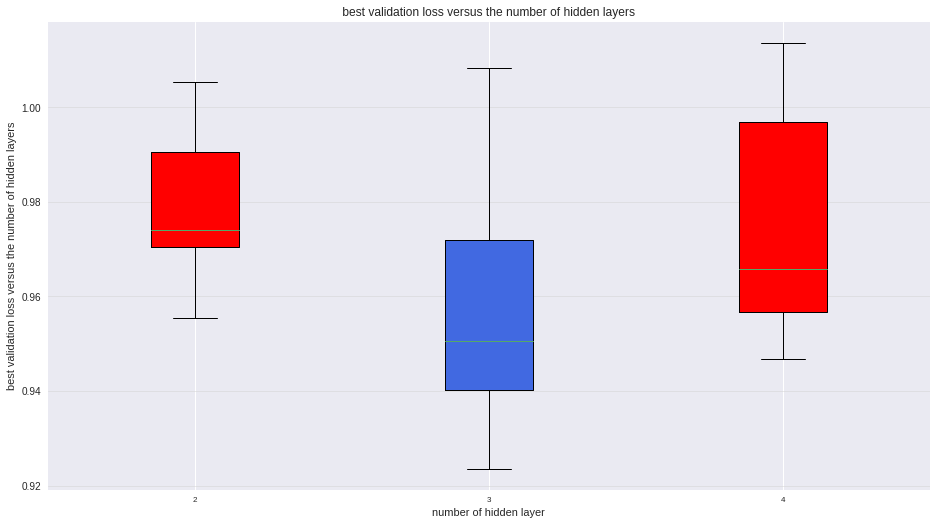

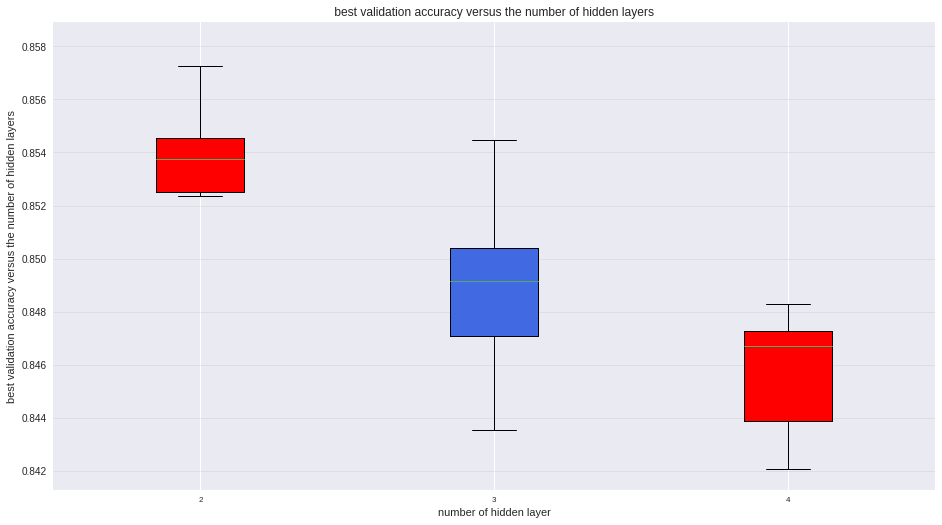

In [64]:
# plot the summary statistics of the best validation loss and accuracy versus the number of hidden layers

plotBoxes( best_validation_loss, ' best validation loss versus the number of hidden layers ', 'number of hidden layer',[2,3,4])
plotBoxes( best_validation_accuracy, ' best validation accuracy versus the number of hidden layers ','number of hidden layer',[2,3,4])


## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [17]:
#1 layer and 100 hidden neurons 
def build_model_1_layer():
  model = Sequential()
  model.add(Dense(100, input_dim=256, activation = 'relu', name='hidden'))
  return model

def model_compile_plot(model, title):
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=0, validation_data=(x_test, y_test))
  plot_history(history, title)
  
def build_model_4_layer(batch, dropout):
  model = Sequential()
  model.add(Dense(59, input_dim=256, activation='relu'))
  for i in range(1,4):
    if batch==1:
      model.add(BatchNormalization())
    if dropout==1:
      model.add(Dropout(0.5))
    model.add(Dense(59, activation='relu'))
  model.summary()
  
  return model
  
build_model_4_layer(1,1)  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 59)                15163     
_________________________________________________________________
batch_normalization_1 (Batch (None, 59)                236       
_________________________________________________________________
dropout_1 (Dropout)          (None, 59)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 59)                3540      
_________________________________________________________________
batch_normalization_2 (Batch (None, 59)                236       
_________________________________________________________________
dropout_2 (Dropout)          (None, 59)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 59)                3540      
__________

Train on 37946 samples, validate on 13404 samples
Epoch 1/90
37946/37946 [==============================] - 3s 90us/step - loss: 1.3743 - acc: 0.4339 - val_loss: 1.1452 - val_acc: 0.5677
Epoch 2/90
37946/37946 [==============================] - 2s 44us/step - loss: 1.0054 - acc: 0.6507 - val_loss: 0.9415 - val_acc: 0.6900
Epoch 3/90
37946/37946 [==============================] - 2s 45us/step - loss: 0.8392 - acc: 0.7305 - val_loss: 0.8577 - val_acc: 0.7205
Epoch 4/90
37946/37946 [==============================] - 2s 44us/step - loss: 0.7582 - acc: 0.7613 - val_loss: 0.8230 - val_acc: 0.7365
Epoch 5/90
37946/37946 [==============================] - 2s 43us/step - loss: 0.6993 - acc: 0.7839 - val_loss: 0.7792 - val_acc: 0.7546
Epoch 6/90
37946/37946 [==============================] - 2s 44us/step - loss: 0.6571 - acc: 0.7981 - val_loss: 0.7273 - val_acc: 0.7772
Epoch 7/90
19328/37946 [==============>...............] - ETA: 0s - loss: 0.6372 - acc: 0.802937946/37946 [=====================

36864/37946 [============================>.] - ETA: 0s - loss: 0.2929 - acc: 0.908037946/37946 [==============================] - 2s 44us/step - loss: 0.2940 - acc: 0.9073 - val_loss: 0.5068 - val_acc: 0.8676
Epoch 59/90
37946/37946 [==============================] - 2s 44us/step - loss: 0.2903 - acc: 0.9104 - val_loss: 0.5012 - val_acc: 0.8721
Epoch 60/90
37946/37946 [==============================] - 2s 45us/step - loss: 0.2885 - acc: 0.9109 - val_loss: 0.5133 - val_acc: 0.8694
Epoch 61/90
37946/37946 [==============================] - 2s 44us/step - loss: 0.2892 - acc: 0.9104 - val_loss: 0.4960 - val_acc: 0.8723
Epoch 62/90
37946/37946 [==============================] - 2s 44us/step - loss: 0.2861 - acc: 0.9124 - val_loss: 0.5027 - val_acc: 0.8706
Epoch 63/90
37946/37946 [==============================] - 2s 44us/step - loss: 0.2848 - acc: 0.9108 - val_loss: 0.5138 - val_acc: 0.8652
Epoch 64/90
37946/37946 [==============================] - 2s 43us/step - loss: 0.2824 - acc: 0.9127 

 3072/37946 [=>............................] - ETA: 1s - loss: 0.3632 - acc: 0.882237946/37946 [==============================] - 2s 59us/step - loss: 0.3780 - acc: 0.8799 - val_loss: 0.5803 - val_acc: 0.8439
Epoch 29/90
37946/37946 [==============================] - 2s 58us/step - loss: 0.3756 - acc: 0.8808 - val_loss: 0.5891 - val_acc: 0.8421
Epoch 30/90
37946/37946 [==============================] - 2s 59us/step - loss: 0.3682 - acc: 0.8841 - val_loss: 0.5724 - val_acc: 0.8482
Epoch 31/90
37946/37946 [==============================] - 2s 59us/step - loss: 0.3638 - acc: 0.8853 - val_loss: 0.5904 - val_acc: 0.8358
Epoch 32/90
37946/37946 [==============================] - 2s 58us/step - loss: 0.3637 - acc: 0.8846 - val_loss: 0.5511 - val_acc: 0.8511
Epoch 33/90
37946/37946 [==============================] - 2s 59us/step - loss: 0.3581 - acc: 0.8857 - val_loss: 0.5583 - val_acc: 0.8534
Epoch 34/90
37946/37946 [==============================] - 2s 59us/step - loss: 0.3524 - acc: 0.8895 

 3072/37946 [=>............................] - ETA: 1s - loss: 0.2661 - acc: 0.914137946/37946 [==============================] - 2s 59us/step - loss: 0.2895 - acc: 0.9069 - val_loss: 0.5592 - val_acc: 0.8627
Epoch 86/90
37946/37946 [==============================] - 2s 58us/step - loss: 0.2954 - acc: 0.9077 - val_loss: 0.6227 - val_acc: 0.8509
Epoch 87/90
37946/37946 [==============================] - 2s 59us/step - loss: 0.2912 - acc: 0.9079 - val_loss: 0.5589 - val_acc: 0.8643
Epoch 88/90
37946/37946 [==============================] - 2s 58us/step - loss: 0.2871 - acc: 0.9084 - val_loss: 0.5573 - val_acc: 0.8624
Epoch 89/90
37946/37946 [==============================] - 2s 59us/step - loss: 0.2822 - acc: 0.9098 - val_loss: 0.5516 - val_acc: 0.8589
Epoch 90/90
37946/37946 [==============================] - 2s 58us/step - loss: 0.2866 - acc: 0.9087 - val_loss: 0.5914 - val_acc: 0.8600
Train on 37946 samples, validate on 13404 samples
Epoch 1/90
37946/37946 [===========================

35072/37946 [==========================>...] - ETA: 0s - loss: 3.6758 - acc: 0.195537946/37946 [==============================] - 2s 45us/step - loss: 3.6165 - acc: 0.1964 - val_loss: 2.6245 - val_acc: 0.1844
Epoch 14/90
37946/37946 [==============================] - 2s 45us/step - loss: 5.0340 - acc: 0.1384 - val_loss: 3.0570 - val_acc: 0.1475
Epoch 15/90
37946/37946 [==============================] - 2s 46us/step - loss: 5.1062 - acc: 0.1781 - val_loss: 11.5830 - val_acc: 0.1301
Epoch 16/90
37946/37946 [==============================] - 2s 46us/step - loss: 6.2835 - acc: 0.1746 - val_loss: 4.7658 - val_acc: 0.2150
Epoch 17/90
37946/37946 [==============================] - 2s 45us/step - loss: 3.6355 - acc: 0.1999 - val_loss: 2.8792 - val_acc: 0.2277
Epoch 18/90
37946/37946 [==============================] - 2s 46us/step - loss: 6.5099 - acc: 0.1686 - val_loss: 6.8344 - val_acc: 0.1656
Epoch 19/90
35072/37946 [==========================>...] - ETA: 0s - loss: 5.6041 - acc: 0.149737946

33792/37946 [=========================>....] - ETA: 0s - loss: 7.0075 - acc: 0.145537946/37946 [==============================] - 2s 45us/step - loss: 7.0205 - acc: 0.1459 - val_loss: 7.0802 - val_acc: 0.1507
Epoch 68/90
37946/37946 [==============================] - 2s 45us/step - loss: 5.8350 - acc: 0.1474 - val_loss: 4.8461 - val_acc: 0.1430
Epoch 69/90
37946/37946 [==============================] - 2s 45us/step - loss: 4.8685 - acc: 0.1678 - val_loss: 3.9366 - val_acc: 0.2070
Epoch 70/90
37946/37946 [==============================] - 2s 45us/step - loss: 5.3579 - acc: 0.2235 - val_loss: 6.6788 - val_acc: 0.1500
Epoch 71/90
37946/37946 [==============================] - 2s 46us/step - loss: 4.9988 - acc: 0.1532 - val_loss: 3.9856 - val_acc: 0.1902
Epoch 72/90
37946/37946 [==============================] - 2s 45us/step - loss: 4.5694 - acc: 0.1704 - val_loss: 5.0982 - val_acc: 0.1344
Epoch 73/90
34816/37946 [==========================>...] - ETA: 0s - loss: 6.8142 - acc: 0.240537946/

 3200/37946 [=>............................] - ETA: 1s - loss: 0.2682 - acc: 0.913137946/37946 [==============================] - 2s 57us/step - loss: 0.2593 - acc: 0.9131 - val_loss: 0.4351 - val_acc: 0.8672
Epoch 32/90
37946/37946 [==============================] - 2s 57us/step - loss: 0.2556 - acc: 0.9132 - val_loss: 0.4638 - val_acc: 0.8651
Epoch 33/90
37946/37946 [==============================] - 2s 57us/step - loss: 0.2511 - acc: 0.9150 - val_loss: 0.4588 - val_acc: 0.8629
Epoch 34/90
37946/37946 [==============================] - 2s 57us/step - loss: 0.2436 - acc: 0.9181 - val_loss: 0.4392 - val_acc: 0.8644
Epoch 35/90
37946/37946 [==============================] - 2s 56us/step - loss: 0.2529 - acc: 0.9137 - val_loss: 0.4901 - val_acc: 0.8538
Epoch 36/90
37946/37946 [==============================] - 2s 56us/step - loss: 0.2402 - acc: 0.9190 - val_loss: 0.4557 - val_acc: 0.8705
Epoch 37/90
 2304/37946 [>.............................] - ETA: 1s - loss: 0.2248 - acc: 0.921037946/

 2048/37946 [>.............................] - ETA: 1s - loss: 0.1334 - acc: 0.950737946/37946 [==============================] - 2s 57us/step - loss: 0.1467 - acc: 0.9493 - val_loss: 0.5788 - val_acc: 0.8701
Epoch 86/90
37946/37946 [==============================] - 2s 57us/step - loss: 0.1435 - acc: 0.9500 - val_loss: 0.5785 - val_acc: 0.8665
Epoch 87/90
37946/37946 [==============================] - 2s 58us/step - loss: 0.1409 - acc: 0.9524 - val_loss: 0.5895 - val_acc: 0.8688
Epoch 88/90
37946/37946 [==============================] - 2s 56us/step - loss: 0.1430 - acc: 0.9511 - val_loss: 0.5726 - val_acc: 0.8698
Epoch 89/90
37946/37946 [==============================] - 2s 57us/step - loss: 0.1332 - acc: 0.9559 - val_loss: 0.5860 - val_acc: 0.8695
Epoch 90/90
37946/37946 [==============================] - 2s 57us/step - loss: 0.1381 - acc: 0.9532 - val_loss: 0.6167 - val_acc: 0.8624
Train on 37946 samples, validate on 13404 samples
Epoch 1/90
  640/37946 [...........................

28416/37946 [=====================>........] - ETA: 0s - loss: 0.2074 - acc: 0.926837946/37946 [==============================] - 4s 100us/step - loss: 0.2118 - acc: 0.9247 - val_loss: 0.4901 - val_acc: 0.8561
Epoch 50/90
37946/37946 [==============================] - 4s 101us/step - loss: 0.2080 - acc: 0.9262 - val_loss: 0.5305 - val_acc: 0.8450
Epoch 51/90
37946/37946 [==============================] - 4s 101us/step - loss: 0.2011 - acc: 0.9293 - val_loss: 0.5025 - val_acc: 0.8568
Epoch 52/90
37946/37946 [==============================] - 4s 101us/step - loss: 0.1996 - acc: 0.9291 - val_loss: 0.5215 - val_acc: 0.8483
Epoch 53/90
28672/37946 [=====================>........] - ETA: 0s - loss: 0.2032 - acc: 0.929137946/37946 [==============================] - 4s 101us/step - loss: 0.2052 - acc: 0.9281 - val_loss: 0.5206 - val_acc: 0.8522
Epoch 54/90
37946/37946 [==============================] - 4s 101us/step - loss: 0.1991 - acc: 0.9301 - val_loss: 0.5488 - val_acc: 0.8462
Epoch 55/90


36224/37946 [===========================>..] - ETA: 0s - loss: 1.1992 - acc: 0.492537946/37946 [==============================] - 2s 64us/step - loss: 1.1982 - acc: 0.4934 - val_loss: 1.1491 - val_acc: 0.5148
Epoch 15/90
37946/37946 [==============================] - 2s 63us/step - loss: 1.1894 - acc: 0.4963 - val_loss: 1.1567 - val_acc: 0.5234
Epoch 16/90
37946/37946 [==============================] - 2s 63us/step - loss: 1.1857 - acc: 0.4996 - val_loss: 1.1203 - val_acc: 0.5451
Epoch 17/90
37946/37946 [==============================] - 2s 63us/step - loss: 1.1852 - acc: 0.4992 - val_loss: 1.1069 - val_acc: 0.5534
Epoch 18/90
37946/37946 [==============================] - 2s 63us/step - loss: 1.1821 - acc: 0.5012 - val_loss: 1.1067 - val_acc: 0.5787
Epoch 19/90
33920/37946 [=========================>....] - ETA: 0s - loss: 1.1757 - acc: 0.504937946/37946 [==============================] - 2s 62us/step - loss: 1.1749 - acc: 0.5055 - val_loss: 1.0979 - val_acc: 0.5480
Epoch 20/90
37946/

34304/37946 [==========================>...] - ETA: 0s - loss: 1.0105 - acc: 0.608237946/37946 [==============================] - 2s 63us/step - loss: 1.0072 - acc: 0.6099 - val_loss: 0.8999 - val_acc: 0.6912
Epoch 70/90
37946/37946 [==============================] - 2s 62us/step - loss: 1.0078 - acc: 0.6114 - val_loss: 0.8738 - val_acc: 0.7005
Epoch 71/90
37946/37946 [==============================] - 2s 63us/step - loss: 0.9973 - acc: 0.6207 - val_loss: 0.8907 - val_acc: 0.6920
Epoch 72/90
37946/37946 [==============================] - 2s 62us/step - loss: 1.0014 - acc: 0.6151 - val_loss: 0.8892 - val_acc: 0.6955
Epoch 73/90
37946/37946 [==============================] - 2s 63us/step - loss: 1.0003 - acc: 0.6181 - val_loss: 0.8864 - val_acc: 0.6998
Epoch 74/90
36352/37946 [===========================>..] - ETA: 0s - loss: 0.9914 - acc: 0.623937946/37946 [==============================] - 2s 62us/step - loss: 0.9903 - acc: 0.6240 - val_loss: 0.8587 - val_acc: 0.7035
Epoch 75/90
37946/

Epoch 88/90
37946/37946 [==============================] - 2s 59us/step - loss: 2.2923 - acc: 0.2634 - val_loss: 1.9796 - val_acc: 0.3809
Epoch 89/90
37946/37946 [==============================] - 2s 59us/step - loss: 3.3816 - acc: 0.1568 - val_loss: 3.0645 - val_acc: 0.1467
Epoch 90/90
37946/37946 [==============================] - 2s 60us/step - loss: 2.4841 - acc: 0.2803 - val_loss: 1.7770 - val_acc: 0.3782


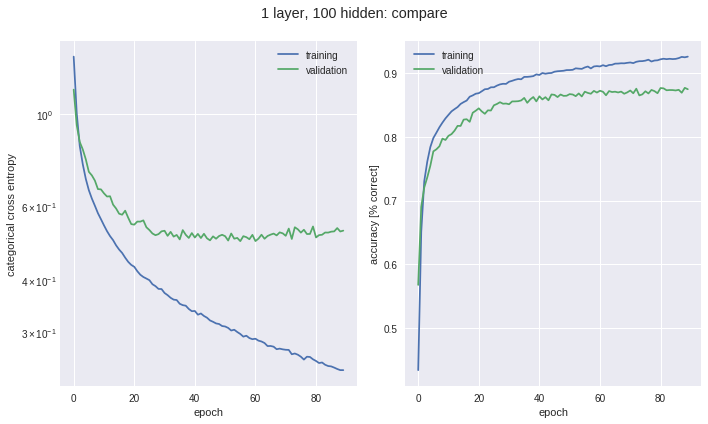

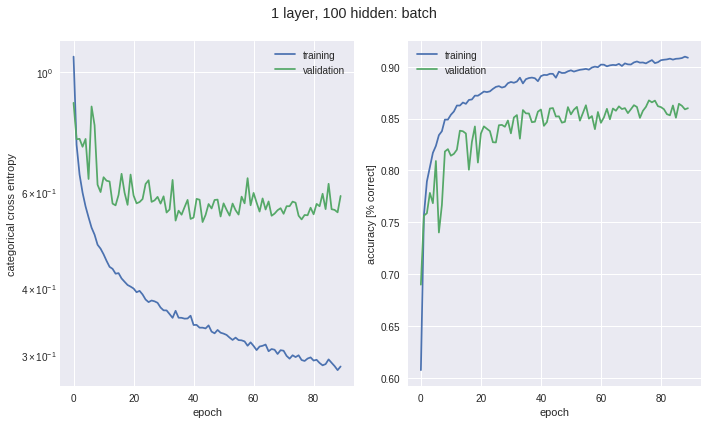

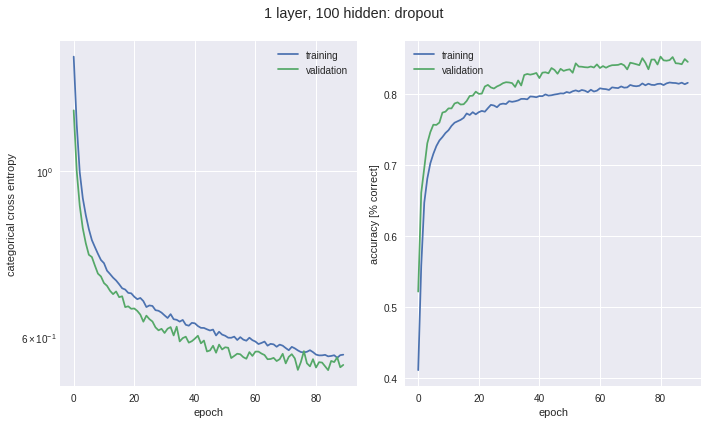

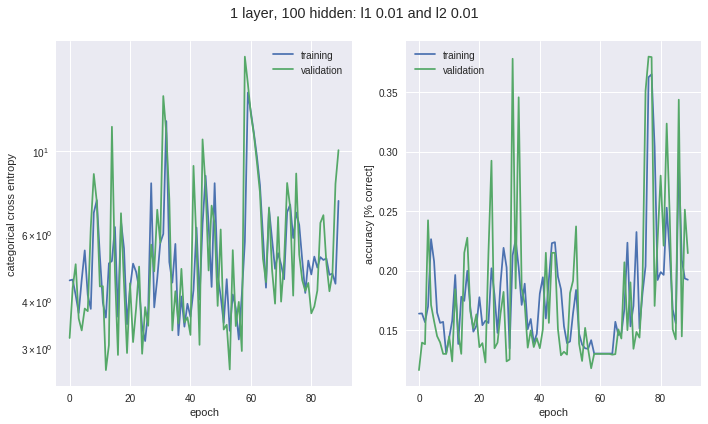

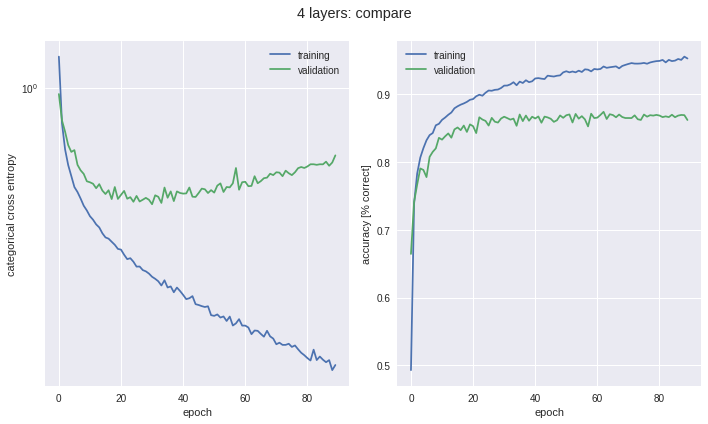

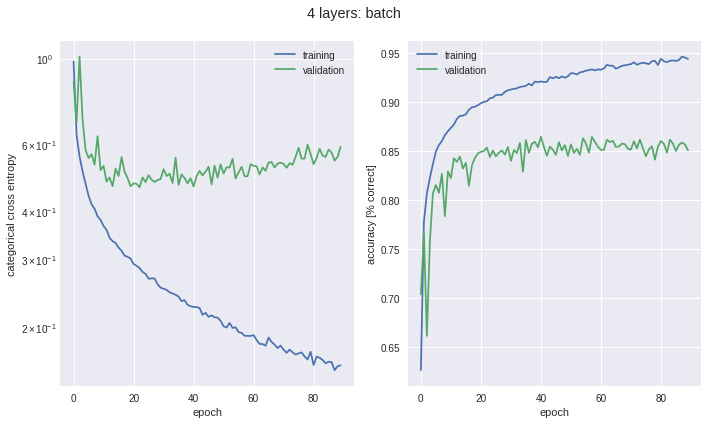

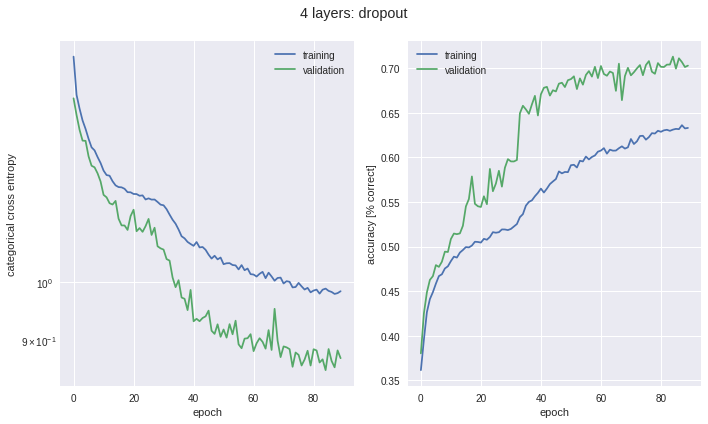

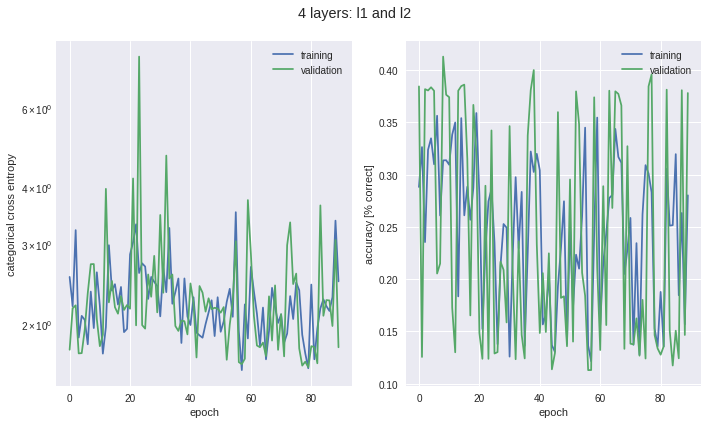

In [57]:
#compare model
model = build_model_1_layer()
model.add(Dense(5, activation='softmax',name = 'Y'))
model_compile_plot(model, '1 layer, 100 hidden: compare')

#batch_normalization layers
model = build_model_1_layer()
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax',name = 'Y'))
model_compile_plot(model, '1 layer, 100 hidden: batch')

#dropout layers
model = build_model_1_layer()
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model_compile_plot(model, '1 layer, 100 hidden: dropout')

#l1- and l2-regularization on weights (kernels) and biases  
model = build_model_1_layer()
model.add(Dense(5, activity_regularizer=regularizers.l1(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model_compile_plot(model, '1 layer, 100 hidden: l1 0.01 and l2 0.01')

# 4 layer
model = build_model_4_layer(0,0)
model.add(Dense(5, activation='softmax'))
model_compile_plot(model, '4 layers: compare')

# batch
model = build_model_4_layer(1,0)
model.add(Dense(5, activation='softmax'))
model_compile_plot(model, '4 layers: batch')

#dropout
model = build_model_1_layer()
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))
model_compile_plot(model, '1 layers: dropout and batch')

#l1- and l2
model = build_model_4_layer(0,0)
model.add(Dense(5, activity_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l2(0.01)))
model_compile_plot(model, '4 layers: l1 and l2')

Train on 34159 samples, validate on 11785 samples
Epoch 1/200
34159/34159 [==============================] - 2s 63us/step - loss: 1.5003 - acc: 0.3639 - val_loss: 1.1710 - val_acc: 0.5364
Epoch 2/200
34159/34159 [==============================] - 2s 56us/step - loss: 1.1378 - acc: 0.5591 - val_loss: 0.9752 - val_acc: 0.6795
Epoch 3/200
34159/34159 [==============================] - 2s 59us/step - loss: 1.0366 - acc: 0.6038 - val_loss: 0.8865 - val_acc: 0.7145
Epoch 4/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.9854 - acc: 0.6236 - val_loss: 0.8853 - val_acc: 0.6852
Epoch 5/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.9594 - acc: 0.6371 - val_loss: 0.8338 - val_acc: 0.7252
Epoch 6/200
30592/34159 [=========================>....] - ETA: 0s - loss: 0.9353 - acc: 0.644134159/34159 [==============================] - 2s 57us/step - loss: 0.9330 - acc: 0.6452 - val_loss: 0.8825 - val_acc: 0.6910
Epoch 7/200
34159/34159 [==============

 9728/34159 [=======>......................] - ETA: 1s - loss: 0.7127 - acc: 0.747534159/34159 [==============================] - 2s 58us/step - loss: 0.7323 - acc: 0.7380 - val_loss: 0.6466 - val_acc: 0.7970
Epoch 61/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.7362 - acc: 0.7352 - val_loss: 0.6433 - val_acc: 0.8056
Epoch 62/200
34159/34159 [==============================] - 2s 59us/step - loss: 0.7334 - acc: 0.7387 - val_loss: 0.6433 - val_acc: 0.8049
Epoch 63/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.7344 - acc: 0.7389 - val_loss: 0.6357 - val_acc: 0.8015
Epoch 64/200
34159/34159 [==============================] - 2s 59us/step - loss: 0.7270 - acc: 0.7394 - val_loss: 0.6414 - val_acc: 0.8015
Epoch 65/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.7315 - acc: 0.7402 - val_loss: 0.6473 - val_acc: 0.8009
Epoch 66/200
 8448/34159 [======>.......................] - ETA: 1s - loss: 0.7436 - acc: 0.7299

 7168/34159 [=====>........................] - ETA: 1s - loss: 0.7010 - acc: 0.746434159/34159 [==============================] - 2s 59us/step - loss: 0.7069 - acc: 0.7483 - val_loss: 0.6221 - val_acc: 0.8092
Epoch 115/200
34159/34159 [==============================] - 2s 61us/step - loss: 0.7055 - acc: 0.7494 - val_loss: 0.6304 - val_acc: 0.8116
Epoch 116/200
34159/34159 [==============================] - 2s 60us/step - loss: 0.6974 - acc: 0.7510 - val_loss: 0.6128 - val_acc: 0.8144
Epoch 117/200
34159/34159 [==============================] - 2s 61us/step - loss: 0.7054 - acc: 0.7486 - val_loss: 0.6301 - val_acc: 0.8063
Epoch 118/200
34159/34159 [==============================] - 2s 59us/step - loss: 0.6981 - acc: 0.7513 - val_loss: 0.6129 - val_acc: 0.8182
Epoch 119/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.6991 - acc: 0.7520 - val_loss: 0.6258 - val_acc: 0.8080
Epoch 120/200
 7040/34159 [=====>........................] - ETA: 1s - loss: 0.7094 - acc: 

 8960/34159 [======>.......................] - ETA: 1s - loss: 0.6680 - acc: 0.758034159/34159 [==============================] - 2s 60us/step - loss: 0.6914 - acc: 0.7550 - val_loss: 0.6084 - val_acc: 0.8231
Epoch 169/200
34159/34159 [==============================] - 2s 59us/step - loss: 0.6875 - acc: 0.7550 - val_loss: 0.6021 - val_acc: 0.8199
Epoch 170/200
34159/34159 [==============================] - 2s 57us/step - loss: 0.6878 - acc: 0.7554 - val_loss: 0.6040 - val_acc: 0.8211
Epoch 171/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.6824 - acc: 0.7540 - val_loss: 0.6062 - val_acc: 0.8157
Epoch 172/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.6816 - acc: 0.7574 - val_loss: 0.6028 - val_acc: 0.8206
Epoch 173/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.6819 - acc: 0.7574 - val_loss: 0.6078 - val_acc: 0.8182
Epoch 174/200
 8704/34159 [======>.......................] - ETA: 1s - loss: 0.6896 - acc: 

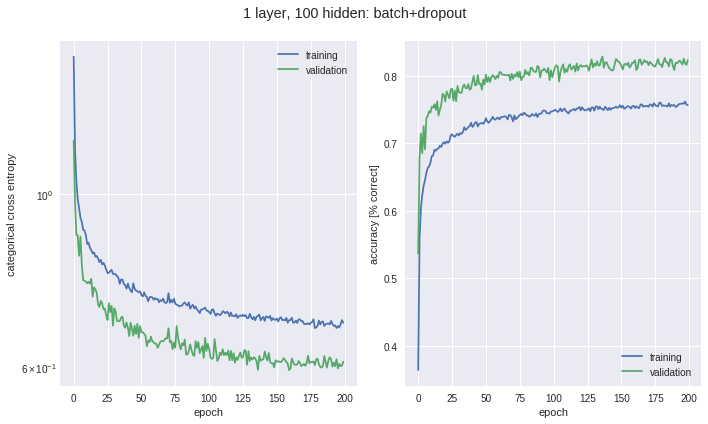

In [19]:

#batch+dropout layers
model = build_model_1_layer()
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))
model_compile_plot(model, '1 layer, 100 hidden: batch+dropout')


Train on 34159 samples, validate on 11785 samples
Epoch 1/200
34159/34159 [==============================] - 5s 133us/step - loss: 1.7114 - acc: 0.2264 - val_loss: 1.5843 - val_acc: 0.2719
Epoch 2/200
34159/34159 [==============================] - 4s 107us/step - loss: 1.5679 - acc: 0.2916 - val_loss: 1.3741 - val_acc: 0.3985
Epoch 3/200
34159/34159 [==============================] - 4s 103us/step - loss: 1.3903 - acc: 0.3964 - val_loss: 1.2965 - val_acc: 0.4532
Epoch 4/200
34159/34159 [==============================] - 4s 106us/step - loss: 1.2726 - acc: 0.4622 - val_loss: 1.1864 - val_acc: 0.5025
Epoch 5/200
10496/34159 [========>.....................] - ETA: 2s - loss: 1.2282 - acc: 0.490734159/34159 [==============================] - 4s 105us/step - loss: 1.1929 - acc: 0.5095 - val_loss: 1.0560 - val_acc: 0.5753
Epoch 6/200
34159/34159 [==============================] - 4s 104us/step - loss: 1.1280 - acc: 0.5482 - val_loss: 0.9557 - val_acc: 0.6361
Epoch 7/200
34159/34159 [========

29440/34159 [========================>.....] - ETA: 0s - loss: 0.7646 - acc: 0.739334159/34159 [==============================] - 4s 103us/step - loss: 0.7664 - acc: 0.7378 - val_loss: 0.7309 - val_acc: 0.7556
Epoch 54/200
34159/34159 [==============================] - 4s 103us/step - loss: 0.7767 - acc: 0.7335 - val_loss: 0.7313 - val_acc: 0.7503
Epoch 55/200
34159/34159 [==============================] - 4s 104us/step - loss: 0.7685 - acc: 0.7347 - val_loss: 0.7213 - val_acc: 0.7554
Epoch 56/200
34159/34159 [==============================] - 4s 105us/step - loss: 0.7680 - acc: 0.7357 - val_loss: 0.7659 - val_acc: 0.7403
Epoch 57/200
29952/34159 [=========================>....] - ETA: 0s - loss: 0.7725 - acc: 0.732834159/34159 [==============================] - 4s 103us/step - loss: 0.7695 - acc: 0.7339 - val_loss: 0.7277 - val_acc: 0.7534
Epoch 58/200
34159/34159 [==============================] - 4s 107us/step - loss: 0.7714 - acc: 0.7338 - val_loss: 0.7533 - val_acc: 0.7453
Epoch 5

30208/34159 [=========================>....] - ETA: 0s - loss: 0.7358 - acc: 0.747634159/34159 [==============================] - 3s 102us/step - loss: 0.7392 - acc: 0.7469 - val_loss: 0.7107 - val_acc: 0.7595
Epoch 106/200
34159/34159 [==============================] - 4s 104us/step - loss: 0.7385 - acc: 0.7449 - val_loss: 0.7090 - val_acc: 0.7606
Epoch 107/200
34159/34159 [==============================] - 4s 104us/step - loss: 0.7399 - acc: 0.7470 - val_loss: 0.7118 - val_acc: 0.7605
Epoch 108/200
34159/34159 [==============================] - 4s 105us/step - loss: 0.7397 - acc: 0.7470 - val_loss: 0.7128 - val_acc: 0.7566
Epoch 109/200
27264/34159 [======================>.......] - ETA: 0s - loss: 0.7383 - acc: 0.746834159/34159 [==============================] - 4s 107us/step - loss: 0.7370 - acc: 0.7475 - val_loss: 0.6971 - val_acc: 0.7618
Epoch 110/200
34159/34159 [==============================] - 4s 107us/step - loss: 0.7369 - acc: 0.7450 - val_loss: 0.6936 - val_acc: 0.7660
Ep

29824/34159 [=========================>....] - ETA: 0s - loss: 0.7229 - acc: 0.751134159/34159 [==============================] - 4s 104us/step - loss: 0.7197 - acc: 0.7521 - val_loss: 0.6780 - val_acc: 0.7705
Epoch 158/200
34159/34159 [==============================] - 4s 105us/step - loss: 0.7164 - acc: 0.7544 - val_loss: 0.6767 - val_acc: 0.7724
Epoch 159/200
34159/34159 [==============================] - 4s 107us/step - loss: 0.7148 - acc: 0.7518 - val_loss: 0.7048 - val_acc: 0.7619
Epoch 160/200
34159/34159 [==============================] - 4s 104us/step - loss: 0.7164 - acc: 0.7555 - val_loss: 0.6769 - val_acc: 0.7704
Epoch 161/200
27904/34159 [=======================>......] - ETA: 0s - loss: 0.7204 - acc: 0.753134159/34159 [==============================] - 4s 105us/step - loss: 0.7203 - acc: 0.7526 - val_loss: 0.6755 - val_acc: 0.7678
Epoch 162/200
34159/34159 [==============================] - 4s 105us/step - loss: 0.7177 - acc: 0.7532 - val_loss: 0.6843 - val_acc: 0.7702
Ep

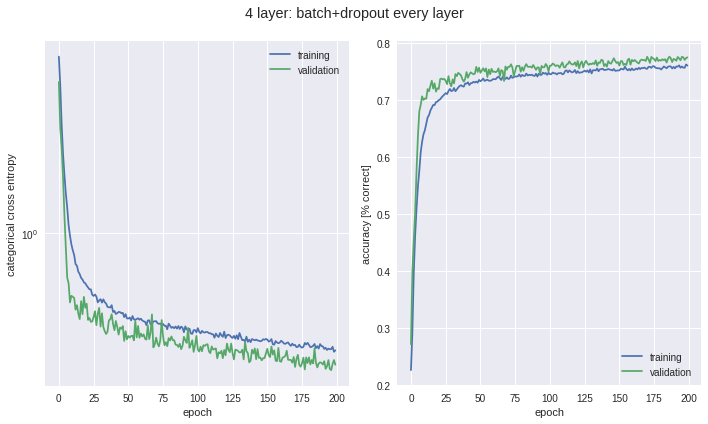

In [20]:
#The following shows that one dropout is better than four dropout
#dropout layers
model = build_model_4_layer(1,1)
model.add(Dense(5, activation='softmax'))
model_compile_plot(model, '4 layer: batch+dropout every layer')
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 59)                15163     
_________________________________________________________________
dense_119 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_120 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_121 (Dense)            (None, 59)                3540      
_________________________________________________________________
batch_normalization_26 (Batc (None, 59)                236       
_________________________________________________________________
dropout_26 (Dropout)         (None, 59)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 5)                 300       
Total para

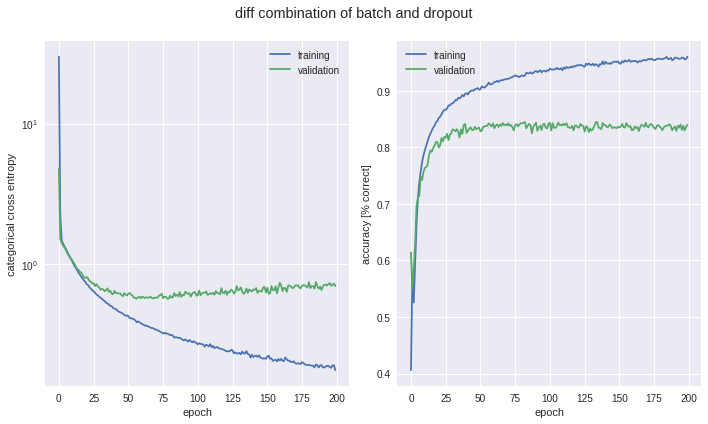

In [42]:

model = Sequential()
model.add(Dense(59, input_dim=256, activation='relu'))
model.add(Dense(59, activation='relu'))        
model.add(Dense(59, activation='relu'))
model.add(Dense(59, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, kernel_regularizer=regularizers.l2(10.0), activation='softmax'))
model.summary()
model_compile_plot(model, 'diff combination of batch and dropout')

Train on 34159 samples, validate on 11785 samples
Epoch 1/200
34159/34159 [==============================] - 2s 64us/step - loss: 1.4824 - acc: 0.3757 - val_loss: 1.1380 - val_acc: 0.6319
Epoch 2/200
34159/34159 [==============================] - 2s 58us/step - loss: 1.1234 - acc: 0.5650 - val_loss: 0.9528 - val_acc: 0.6597
Epoch 3/200
34159/34159 [==============================] - 2s 57us/step - loss: 1.0108 - acc: 0.6171 - val_loss: 0.8625 - val_acc: 0.7134
Epoch 4/200
34159/34159 [==============================] - 2s 60us/step - loss: 0.9619 - acc: 0.6397 - val_loss: 0.8429 - val_acc: 0.7196
Epoch 5/200
34159/34159 [==============================] - 2s 57us/step - loss: 0.9379 - acc: 0.6518 - val_loss: 0.8398 - val_acc: 0.7162
Epoch 6/200
31104/34159 [==========================>...] - ETA: 0s - loss: 0.9120 - acc: 0.662234159/34159 [==============================] - 2s 58us/step - loss: 0.9113 - acc: 0.6620 - val_loss: 0.7905 - val_acc: 0.7420
Epoch 7/200
34159/34159 [==============

 8832/34159 [======>.......................] - ETA: 1s - loss: 0.7289 - acc: 0.735634159/34159 [==============================] - 2s 59us/step - loss: 0.7433 - acc: 0.7347 - val_loss: 0.6508 - val_acc: 0.8063
Epoch 61/200
34159/34159 [==============================] - 2s 57us/step - loss: 0.7364 - acc: 0.7359 - val_loss: 0.6380 - val_acc: 0.8028
Epoch 62/200
34159/34159 [==============================] - 2s 59us/step - loss: 0.7371 - acc: 0.7346 - val_loss: 0.6492 - val_acc: 0.7993
Epoch 63/200
34159/34159 [==============================] - 2s 59us/step - loss: 0.7322 - acc: 0.7388 - val_loss: 0.6538 - val_acc: 0.7868
Epoch 64/200
34159/34159 [==============================] - 2s 59us/step - loss: 0.7339 - acc: 0.7380 - val_loss: 0.6459 - val_acc: 0.8074
Epoch 65/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.7229 - acc: 0.7386 - val_loss: 0.6381 - val_acc: 0.8046
Epoch 66/200
 8448/34159 [======>.......................] - ETA: 1s - loss: 0.7153 - acc: 0.7425

 9472/34159 [=======>......................] - ETA: 1s - loss: 0.7013 - acc: 0.737534159/34159 [==============================] - 2s 58us/step - loss: 0.6982 - acc: 0.7485 - val_loss: 0.6165 - val_acc: 0.8186
Epoch 115/200
34159/34159 [==============================] - 2s 57us/step - loss: 0.6917 - acc: 0.7519 - val_loss: 0.6285 - val_acc: 0.8123
Epoch 116/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.6921 - acc: 0.7535 - val_loss: 0.6028 - val_acc: 0.8210
Epoch 117/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.6986 - acc: 0.7492 - val_loss: 0.6056 - val_acc: 0.8186
Epoch 118/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.6886 - acc: 0.7544 - val_loss: 0.6082 - val_acc: 0.8197
Epoch 119/200
34159/34159 [==============================] - 2s 59us/step - loss: 0.6955 - acc: 0.7539 - val_loss: 0.6117 - val_acc: 0.8151
Epoch 120/200
 7808/34159 [=====>........................] - ETA: 1s - loss: 0.6786 - acc: 

10496/34159 [========>.....................] - ETA: 1s - loss: 0.6809 - acc: 0.759034159/34159 [==============================] - 2s 57us/step - loss: 0.6814 - acc: 0.7585 - val_loss: 0.5927 - val_acc: 0.8242
Epoch 169/200
34159/34159 [==============================] - 2s 60us/step - loss: 0.6693 - acc: 0.7635 - val_loss: 0.5913 - val_acc: 0.8234
Epoch 170/200
34159/34159 [==============================] - 2s 57us/step - loss: 0.6730 - acc: 0.7605 - val_loss: 0.5806 - val_acc: 0.8293
Epoch 171/200
34159/34159 [==============================] - 2s 58us/step - loss: 0.6734 - acc: 0.7591 - val_loss: 0.5979 - val_acc: 0.8240
Epoch 172/200
34159/34159 [==============================] - 2s 57us/step - loss: 0.6647 - acc: 0.7652 - val_loss: 0.5892 - val_acc: 0.8289
Epoch 173/200
34159/34159 [==============================] - 2s 59us/step - loss: 0.6672 - acc: 0.7643 - val_loss: 0.6047 - val_acc: 0.8225
Epoch 174/200
 6912/34159 [=====>........................] - ETA: 1s - loss: 0.6532 - acc: 

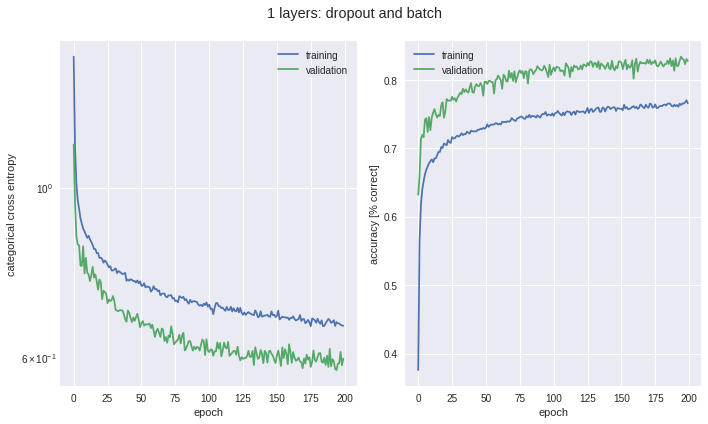

In [18]:

#dropout
model = build_model_1_layer()
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))
model_compile_plot(model, '1 layers: dropout and batch')

In [0]:
# plot the final graph
def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('accuracy [% correct]')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_compare(data1, label1, data2, label2, data3, label3, data4, label4, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(data1, label = label1)
    ax1.plot(data2, label = label2)
    ax2.plot(data3, label = label3)
    ax2.plot(data4, label = label4)
    finalize_standardplot(fig, ax1, ax2)
    return fig


In [0]:
  # After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises 
# together with the learning curves of the current version.
# For proper comparison, plot also the learning curves of the two current models in a third figure.
  
#previous 1 layer
model = build_model_1_layer()
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=0, validation_data=(x_test, y_test))
layer_1_old = history.history['acc']
plot_history(history, 'prev 1')

In [2]:
# current 1 layer
model = build_model_1_layer()
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(5, kernel_regularizer=regularizers.l2(0.0001), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=0, validation_data=(x_test, y_test))
layer_1_new = history.history['acc']
plot_history(history, 'curr 1')

NameError: ignored

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 59)                15163     
_________________________________________________________________
dense_27 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_28 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_29 (Dense)             (None, 59)                3540      
Total params: 25,783
Trainable params: 25,783
Non-trainable params: 0
_________________________________________________________________


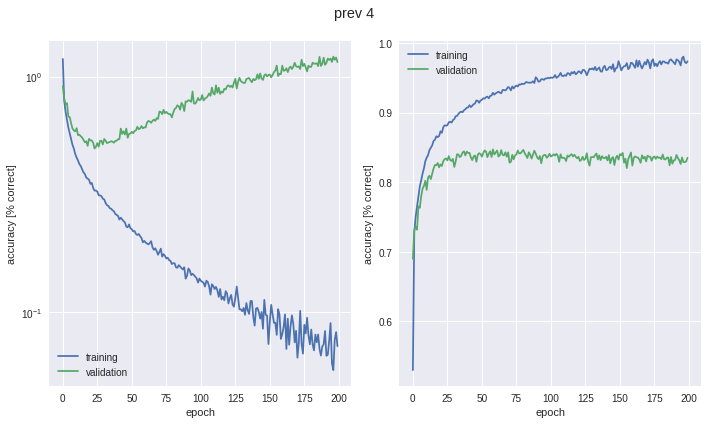

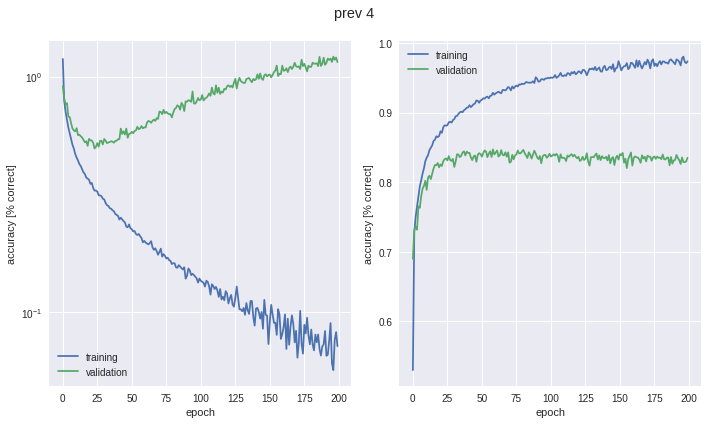

In [47]:

#previous 4 layer
model = build_model_4_layer(0,0)
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=0, validation_data=(x_test, y_test))
layer_4_old = history.history['acc']
plot_history(history, 'prev 4')

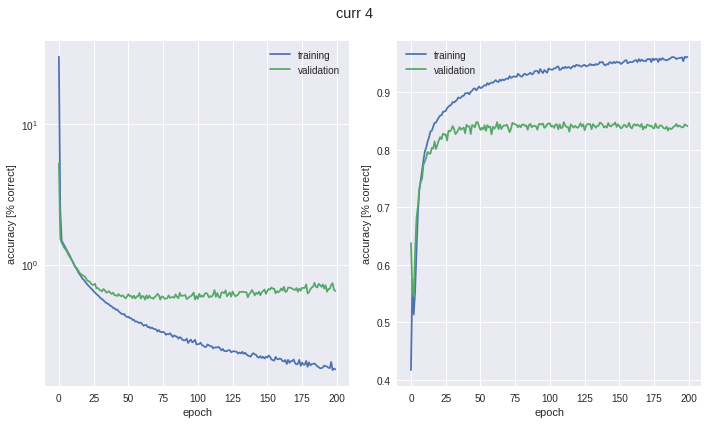

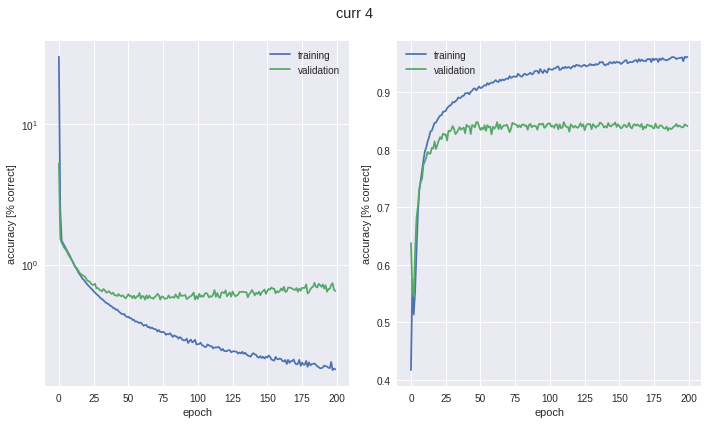

In [46]:
#current 4 layer
model = Sequential()
model.add(Dense(59, input_dim=256, activation='relu'))
model.add(Dense(59, activation='relu'))        
model.add(Dense(59, activation='relu'))
model.add(Dense(59, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, kernel_regularizer=regularizers.l2(10.0), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=0, validation_data=(x_test, y_test))
layer_4_new = history.history['acc']

plot_history(history, 'curr 4')

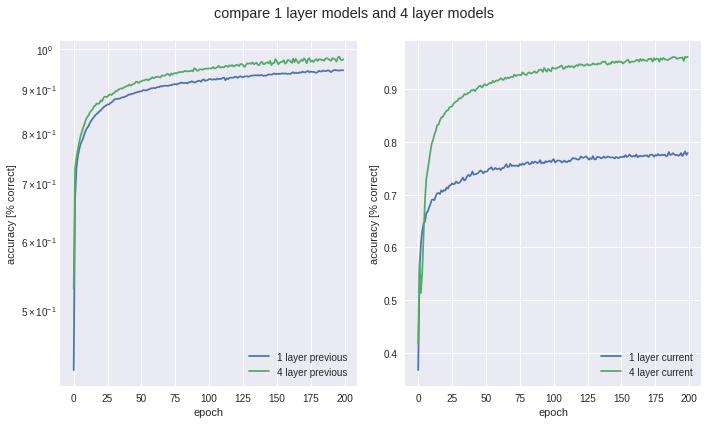

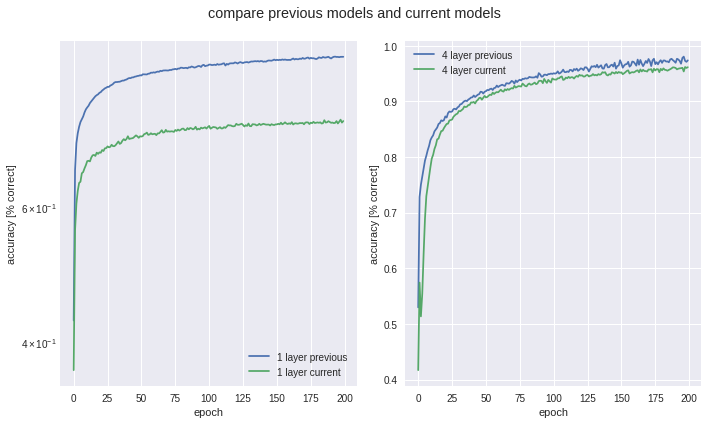

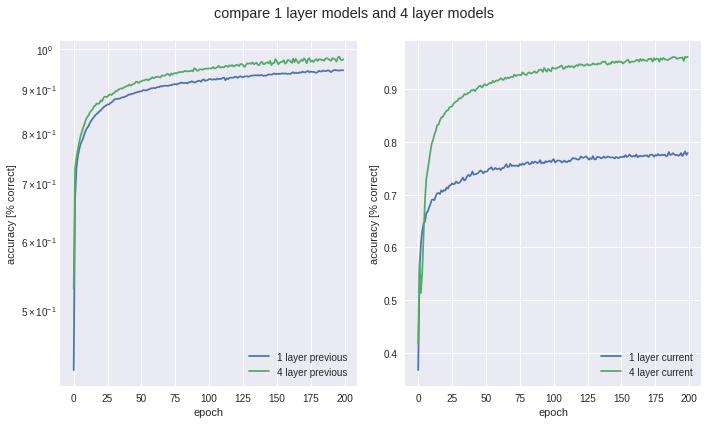

In [56]:
#plot

#previous 1 layer vs 4 layer

#new 1 layer vs 4 layer


plot_compare(layer_1_old, '1 layer previous', layer_1_new, '1 layer current', layer_4_old, '4 layer previous', layer_4_new, '4 layer current', 'compare previous models and current models')


plot_compare(layer_1_old, '1 layer previous', layer_4_old, '4 layer previous', layer_1_new, '1 layer current', layer_4_new, '4 layer current', 'compare 1 layer models and 4 layer models')




## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [0]:
data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')
x_train = data_train['X']
y_train = data_train['y']
x_test = data_test['X']
y_test = data_test['y']

In [42]:
# preprocess the sample for 2D convovution layer
img_rows, img_cols = 16, 16
from keras import backend as K
batch_size = 128
num_classes = 5
epochs = 50
if K.image_data_format() == 'channels_first':
    x_train_r = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test_r = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    print( x_train.shape)
    x_train_r = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    print(x_train_r.shape)
    x_test_r = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train_r = x_train_r.astype('float32')
x_test_r = x_test_r.astype('float32')
# x_train_r /= 255
# x_test_r /= 255
print('x_train shape:', x_test_r.shape)
print(x_train_r.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(input_shape)
print(y_train)

(34159, 256)
(34159, 16, 16, 1)
x_train shape: (11785, 16, 16, 1)
34159 train samples
11785 test samples
(16, 16, 1)
[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]


In [43]:
#   keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), 
#   padding='valid', data_format=None, dilation_rate=(1, 1), 
#   activation=None, use_bias=True, kernel_initializer='glorot_uniform', 
#   bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
#   activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
# model = Sequential()
# model.add(Conv2D(5, kernel_size=(3, 3), activation='relu', input_shape=(16,16,1))
# model.add(Dense(5, activation='softmax',name = 'Y'))
# model_compile_plot(model, 'convolution')

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(16,16,1),))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_r, y_train, batch_size=128, epochs=90, verbose=1, validation_data=(x_test_r, y_test))
plot_history(history, 'convolution')


Train on 34159 samples, validate on 11785 samples
Epoch 1/90
34159/34159 [==============================] - 13s 390us/step - loss: 1.0006 - acc: 0.6548 - val_loss: 0.6033 - val_acc: 0.8372
Epoch 2/90
34159/34159 [==============================] - 13s 380us/step - loss: 0.5340 - acc: 0.8515 - val_loss: 0.5301 - val_acc: 0.8620
Epoch 3/90
34159/34159 [==============================] - 13s 375us/step - loss: 0.4664 - acc: 0.8714 - val_loss: 0.4990 - val_acc: 0.8712
Epoch 4/90
34159/34159 [==============================] - 13s 384us/step - loss: 0.4318 - acc: 0.8813 - val_loss: 0.4734 - val_acc: 0.8785
Epoch 5/90
34159/34159 [==============================] - 14s 396us/step - loss: 0.4101 - acc: 0.8879 - val_loss: 0.4634 - val_acc: 0.8830
Epoch 6/90
34159/34159 [==============================] - 13s 388us/step - loss: 0.3914 - acc: 0.8925 - val_loss: 0.4646 - val_acc: 0.8826
Epoch 7/90
34159/34159 [==============================] - 13s 385us/step - loss: 0.3766 - acc: 0.8960 - val_loss: 0.

KeyboardInterrupt: 

In [17]:

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(16,16,1)))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
#model.add(BatchNormalization(epsilon=0.001,  axis=-1, momentum=0.99, weights=None, beta_init='zero',  gamma_regularizer=None, beta_regularizer=None))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_r, y_train, batch_size=128, epochs=90, verbose=1, validation_data=(x_test_r, y_test))
plot_history(history, 'convolution')

Train on 34159 samples, validate on 11785 samples
Epoch 1/90
 2048/34159 [>.............................] - ETA: 7s - loss: 1.6062 - acc: 0.2290

KeyboardInterrupt: ignored

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 15, 15, 32)        160       
_________________________________________________________________
Conv2 (Conv2D)               (None, 14, 14, 64)        8256      
_________________________________________________________________
dropout_86 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 7, 14, 64)         0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 6, 13, 64)         16448     
_________________________________________________________________
flatten_35 (Flatten)         (None, 4992)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 32)                159776    
__________

12672/34159 [==========>...................] - ETA: 2s - loss: 0.4145 - acc: 0.868234159/34159 [==============================] - 5s 140us/step - loss: 0.4181 - acc: 0.8665 - val_loss: 0.4244 - val_acc: 0.8662
Epoch 46/90
34159/34159 [==============================] - 5s 139us/step - loss: 0.4122 - acc: 0.8652 - val_loss: 0.4638 - val_acc: 0.8563
Epoch 47/90
34159/34159 [==============================] - 5s 138us/step - loss: 0.4130 - acc: 0.8662 - val_loss: 0.4445 - val_acc: 0.8641
Epoch 48/90
34159/34159 [==============================] - 5s 139us/step - loss: 0.4162 - acc: 0.8643 - val_loss: 0.4501 - val_acc: 0.8630
Epoch 49/90
14336/34159 [===========>..................] - ETA: 2s - loss: 0.4101 - acc: 0.867134159/34159 [==============================] - 5s 139us/step - loss: 0.4070 - acc: 0.8688 - val_loss: 0.4528 - val_acc: 0.8618
Epoch 50/90
34159/34159 [==============================] - 5s 139us/step - loss: 0.4086 - acc: 0.8657 - val_loss: 0.4858 - val_acc: 0.8451
Epoch 51/90


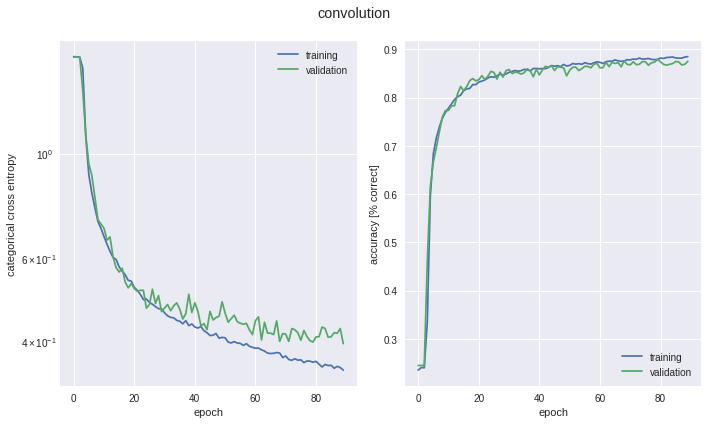

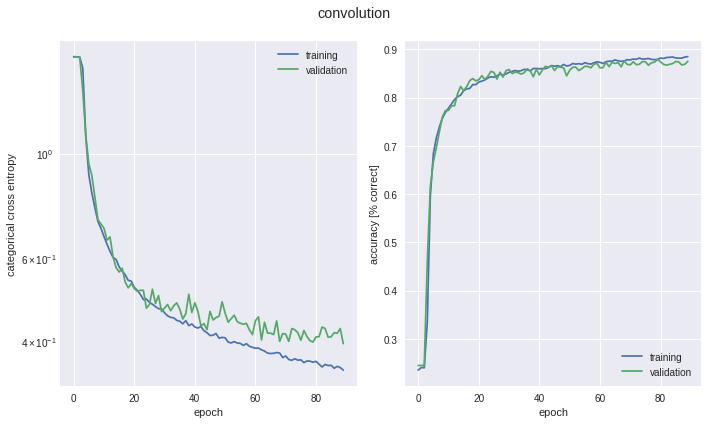

In [77]:



model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(16,16,1),name = "Conv1"))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (2, 2), activation = 'selu',name = "Conv2"))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,1)))
model.add(Conv2D(64, (2, 2), activation = 'selu',name = "Conv3"))
model.add(Flatten())
#model.add(BatchNormalization(epsilon=0.001,  axis=-1, momentum=0.99, weights=None, beta_init='zero',  gamma_regularizer=None, beta_regularizer=None))

model.add(Dense(32, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(x_train_r, y_train, batch_size=128, epochs=90, verbose=1, validation_data=(x_test_r, y_test))
plot_history(history, 'convolution')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 16, 16, 32)        160       
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 16, 32)        4128      
_________________________________________________________________
dropout_57 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 8, 8, 32)          4128      
_________________________________________________________________
Conv4 (Conv2D)               (None, 8, 8, 32)          4128      
_________________________________________________________________
dropout_58 (Dropout)         (None, 8, 8, 32)          0         
__________

29696/34159 [=========================>....] - ETA: 0s - loss: 1.5983 - acc: 0.246534159/34159 [==============================] - 6s 163us/step - loss: 1.5979 - acc: 0.2467 - val_loss: 1.5997 - val_acc: 0.2445
Epoch 40/300
34159/34159 [==============================] - 6s 163us/step - loss: 1.5979 - acc: 0.2480 - val_loss: 1.6000 - val_acc: 0.2445
Epoch 41/300
34159/34159 [==============================] - 6s 164us/step - loss: 1.5977 - acc: 0.2486 - val_loss: 1.5998 - val_acc: 0.2445
Epoch 42/300
34159/34159 [==============================] - 6s 162us/step - loss: 1.5977 - acc: 0.2478 - val_loss: 1.6007 - val_acc: 0.2445
Epoch 43/300
  128/34159 [..............................] - ETA: 5s - loss: 1.5940 - acc: 0.226634159/34159 [==============================] - 6s 162us/step - loss: 1.5977 - acc: 0.2487 - val_loss: 1.6000 - val_acc: 0.2445
Epoch 44/300
34159/34159 [==============================] - 6s 162us/step - loss: 1.5978 - acc: 0.2469 - val_loss: 1.6003 - val_acc: 0.2445
Epoch 4

30080/34159 [=========================>....] - ETA: 0s - loss: 0.3075 - acc: 0.891834159/34159 [==============================] - 6s 162us/step - loss: 0.3104 - acc: 0.8904 - val_loss: 0.2839 - val_acc: 0.9045
Epoch 92/300
34159/34159 [==============================] - 6s 162us/step - loss: 0.3147 - acc: 0.8898 - val_loss: 0.2813 - val_acc: 0.9056
Epoch 93/300
34159/34159 [==============================] - 6s 164us/step - loss: 0.3091 - acc: 0.8932 - val_loss: 0.2733 - val_acc: 0.9088
Epoch 94/300
34159/34159 [==============================] - 6s 162us/step - loss: 0.3051 - acc: 0.8927 - val_loss: 0.2555 - val_acc: 0.9157
Epoch 95/300
  128/34159 [..............................] - ETA: 6s - loss: 0.2788 - acc: 0.882834159/34159 [==============================] - 6s 162us/step - loss: 0.3105 - acc: 0.8912 - val_loss: 0.2615 - val_acc: 0.9139
Epoch 96/300
34159/34159 [==============================] - 6s 162us/step - loss: 0.2998 - acc: 0.8944 - val_loss: 0.2534 - val_acc: 0.9167
Epoch 9

29312/34159 [========================>.....] - ETA: 0s - loss: 0.2221 - acc: 0.922934159/34159 [==============================] - 5s 161us/step - loss: 0.2257 - acc: 0.9217 - val_loss: 0.2160 - val_acc: 0.9326
Epoch 194/300
34159/34159 [==============================] - 6s 162us/step - loss: 0.2261 - acc: 0.9223 - val_loss: 0.2205 - val_acc: 0.9342
Epoch 195/300
34159/34159 [==============================] - 6s 162us/step - loss: 0.2187 - acc: 0.9247 - val_loss: 0.2140 - val_acc: 0.9368
Epoch 196/300
34159/34159 [==============================] - 6s 162us/step - loss: 0.2210 - acc: 0.9229 - val_loss: 0.2227 - val_acc: 0.9338
Epoch 197/300
34159/34159 [==============================] - 6s 164us/step - loss: 0.2176 - acc: 0.9255 - val_loss: 0.2325 - val_acc: 0.9310
Epoch 198/300
34159/34159 [==============================] - 6s 161us/step - loss: 0.2203 - acc: 0.9238 - val_loss: 0.2207 - val_acc: 0.9350
Epoch 199/300
34159/34159 [==============================] - 6s 162us/step - loss: 0.

29312/34159 [========================>.....] - ETA: 0s - loss: 0.1960 - acc: 0.933634159/34159 [==============================] - 6s 162us/step - loss: 0.1975 - acc: 0.9334 - val_loss: 0.2359 - val_acc: 0.9379
Epoch 296/300
34159/34159 [==============================] - 6s 162us/step - loss: 0.1960 - acc: 0.9312 - val_loss: 0.2342 - val_acc: 0.9332
Epoch 297/300
34159/34159 [==============================] - 6s 164us/step - loss: 0.1996 - acc: 0.9314 - val_loss: 0.2467 - val_acc: 0.9351
Epoch 298/300
34159/34159 [==============================] - 6s 163us/step - loss: 0.2010 - acc: 0.9310 - val_loss: 0.2323 - val_acc: 0.9354
Epoch 299/300
34159/34159 [==============================] - 6s 162us/step - loss: 0.1981 - acc: 0.9319 - val_loss: 0.2365 - val_acc: 0.9331
Epoch 300/300
34159/34159 [==============================] - 6s 163us/step - loss: 0.2048 - acc: 0.9297 - val_loss: 0.2289 - val_acc: 0.9375


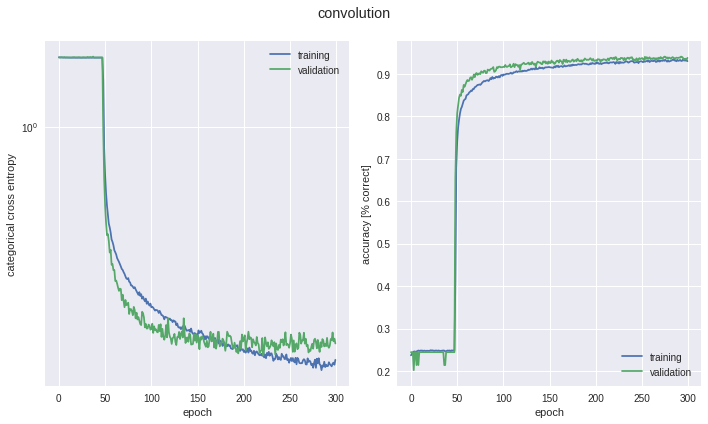

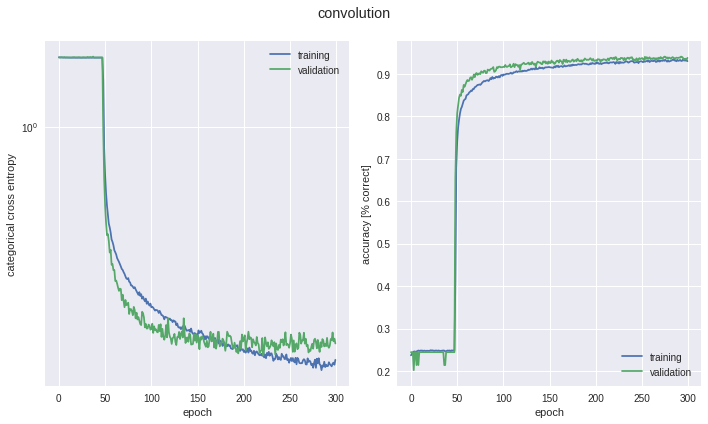

In [40]:
#best model built in March 26, 10:35 with fast and stable convegence to 0.92
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(16,16,1),name = "Conv1",activation = 'selu',padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv2",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv3",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv4",padding = 'same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv5",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv6",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(x_train_r, y_train, batch_size=128, epochs= 500, verbose=1, validation_data=(x_test_r, y_test))
plot_history(history, 'convolution')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 16, 16, 32)        160       
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 16, 32)        4128      
_________________________________________________________________
dropout_141 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 8, 8, 32)          4128      
_________________________________________________________________
Conv4 (Conv2D)               (None, 8, 8, 32)          4128      
_________________________________________________________________
dropout_142 (Dropout)        (None, 8, 8, 32)          0         
__________

  512/34159 [..............................] - ETA: 5s - loss: 1.5909 - acc: 0.285234159/34159 [==============================] - 6s 181us/step - loss: 1.5977 - acc: 0.2489 - val_loss: 1.6026 - val_acc: 0.2141
Epoch 40/500
34159/34159 [==============================] - 6s 179us/step - loss: 1.5977 - acc: 0.2476 - val_loss: 1.5998 - val_acc: 0.2445
Epoch 41/500
34159/34159 [==============================] - 6s 178us/step - loss: 1.5979 - acc: 0.2480 - val_loss: 1.6015 - val_acc: 0.2445
Epoch 42/500
29568/34159 [========================>.....] - ETA: 0s - loss: 1.5980 - acc: 0.246834159/34159 [==============================] - 6s 177us/step - loss: 1.5976 - acc: 0.2482 - val_loss: 1.5999 - val_acc: 0.2445
Epoch 43/500
34159/34159 [==============================] - 6s 178us/step - loss: 1.5979 - acc: 0.2480 - val_loss: 1.6004 - val_acc: 0.2445
Epoch 44/500
34159/34159 [==============================] - 6s 178us/step - loss: 1.5977 - acc: 0.2482 - val_loss: 1.5998 - val_acc: 0.2445
Epoch 4

29696/34159 [=========================>....] - ETA: 0s - loss: 0.3884 - acc: 0.863834159/34159 [==============================] - 6s 179us/step - loss: 0.3845 - acc: 0.8651 - val_loss: 0.3165 - val_acc: 0.8968
Epoch 91/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.3740 - acc: 0.8688 - val_loss: 0.3012 - val_acc: 0.9007
Epoch 92/500
34159/34159 [==============================] - 6s 179us/step - loss: 0.3686 - acc: 0.8699 - val_loss: 0.2960 - val_acc: 0.9013
Epoch 93/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.3609 - acc: 0.8736 - val_loss: 0.2855 - val_acc: 0.9040
Epoch 94/500
  128/34159 [..............................] - ETA: 5s - loss: 0.3651 - acc: 0.843834159/34159 [==============================] - 6s 177us/step - loss: 0.3559 - acc: 0.8756 - val_loss: 0.3066 - val_acc: 0.8966
Epoch 95/500
34159/34159 [==============================] - 6s 178us/step - loss: 0.3573 - acc: 0.8744 - val_loss: 0.2927 - val_acc: 0.9011
Epoch 9

33536/34159 [============================>.] - ETA: 0s - loss: 0.2128 - acc: 0.927634159/34159 [==============================] - 6s 178us/step - loss: 0.2131 - acc: 0.9275 - val_loss: 0.2144 - val_acc: 0.9370
Epoch 192/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.2131 - acc: 0.9273 - val_loss: 0.2221 - val_acc: 0.9365
Epoch 193/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.2127 - acc: 0.9268 - val_loss: 0.2172 - val_acc: 0.9375
Epoch 194/500
34159/34159 [==============================] - 6s 176us/step - loss: 0.2098 - acc: 0.9273 - val_loss: 0.2212 - val_acc: 0.9368
Epoch 195/500
  128/34159 [..............................] - ETA: 6s - loss: 0.2336 - acc: 0.914134159/34159 [==============================] - 6s 175us/step - loss: 0.2084 - acc: 0.9282 - val_loss: 0.2233 - val_acc: 0.9387
Epoch 196/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.2110 - acc: 0.9282 - val_loss: 0.2076 - val_acc: 0.9361
Ep

29312/34159 [========================>.....] - ETA: 0s - loss: 0.1756 - acc: 0.939634159/34159 [==============================] - 6s 178us/step - loss: 0.1790 - acc: 0.9388 - val_loss: 0.2237 - val_acc: 0.9409
Epoch 294/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.1791 - acc: 0.9383 - val_loss: 0.2225 - val_acc: 0.9440
Epoch 295/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.1804 - acc: 0.9379 - val_loss: 0.2343 - val_acc: 0.9395
Epoch 296/500
34048/34159 [============================>.] - ETA: 0s - loss: 0.1784 - acc: 0.940134159/34159 [==============================] - 6s 177us/step - loss: 0.1782 - acc: 0.9400 - val_loss: 0.2265 - val_acc: 0.9410
Epoch 297/500
34159/34159 [==============================] - 6s 176us/step - loss: 0.1792 - acc: 0.9375 - val_loss: 0.2235 - val_acc: 0.9437
Epoch 298/500
34159/34159 [==============================] - 6s 176us/step - loss: 0.1783 - acc: 0.9388 - val_loss: 0.2479 - val_acc: 0.9426
Ep

  128/34159 [..............................] - ETA: 6s - loss: 0.1477 - acc: 0.937534159/34159 [==============================] - 6s 177us/step - loss: 0.1669 - acc: 0.9431 - val_loss: 0.2279 - val_acc: 0.9444
Epoch 345/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.1723 - acc: 0.9411 - val_loss: 0.2275 - val_acc: 0.9423
Epoch 346/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.1672 - acc: 0.9424 - val_loss: 0.2230 - val_acc: 0.9438
Epoch 347/500
29312/34159 [========================>.....] - ETA: 0s - loss: 0.1771 - acc: 0.940634159/34159 [==============================] - 6s 176us/step - loss: 0.1774 - acc: 0.9399 - val_loss: 0.2307 - val_acc: 0.9457
Epoch 348/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.1720 - acc: 0.9411 - val_loss: 0.2305 - val_acc: 0.9442
Epoch 349/500
34159/34159 [==============================] - 6s 176us/step - loss: 0.1690 - acc: 0.9412 - val_loss: 0.2261 - val_acc: 0.9428
Ep

  128/34159 [..............................] - ETA: 7s - loss: 0.1911 - acc: 0.960934159/34159 [==============================] - 6s 177us/step - loss: 0.1629 - acc: 0.9444 - val_loss: 0.2296 - val_acc: 0.9445
Epoch 399/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.1706 - acc: 0.9424 - val_loss: 0.2224 - val_acc: 0.9459
Epoch 400/500
34159/34159 [==============================] - 6s 177us/step - loss: 0.1615 - acc: 0.9447 - val_loss: 0.2456 - val_acc: 0.9437
Epoch 401/500
29312/34159 [========================>.....] - ETA: 0s - loss: 0.1679 - acc: 0.943934159/34159 [==============================] - 6s 177us/step - loss: 0.1677 - acc: 0.9439 - val_loss: 0.2293 - val_acc: 0.9475
Epoch 402/500
34159/34159 [==============================] - 6s 178us/step - loss: 0.1689 - acc: 0.9429 - val_loss: 0.2340 - val_acc: 0.9471
Epoch 403/500
34159/34159 [==============================] - 6s 178us/step - loss: 0.1604 - acc: 0.9448 - val_loss: 0.2236 - val_acc: 0.9443
Ep

Epoch 500/500
34159/34159 [==============================] - 6s 176us/step - loss: 0.1542 - acc: 0.9472 - val_loss: 0.2183 - val_acc: 0.9482


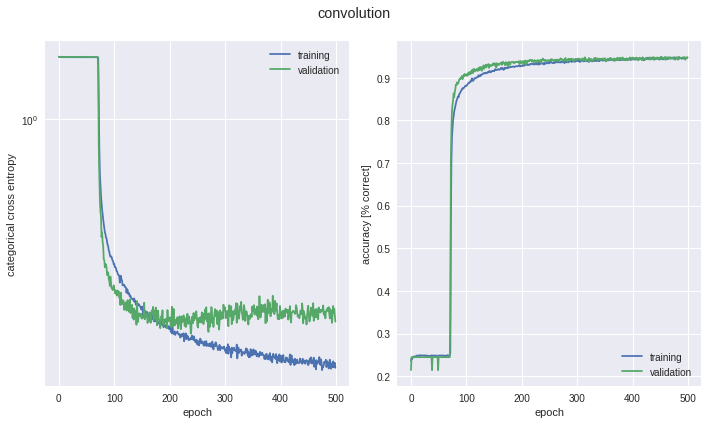

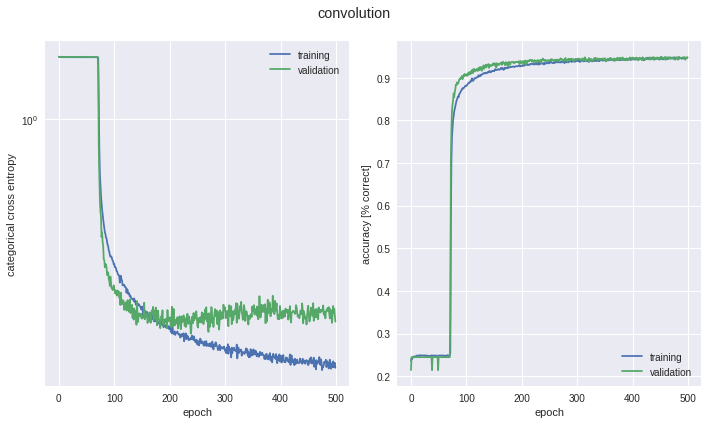

In [74]:
#best 7 conv layer model built in March 26, 14:32
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(16,16,1),name = "Conv1",activation = 'selu',padding = 'same',kernel_initializer = 'glorot_uniform'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv2",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv3",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv4",padding = 'same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv5",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv6",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv7",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(x_train_r, y_train, batch_size=128, epochs= 500, verbose=1, validation_data=(x_test_r, y_test))
plot_history(history, 'convolution')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 16, 16, 32)        160       
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 16, 32)        4128      
_________________________________________________________________
dropout_153 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 8, 8, 32)          4128      
_________________________________________________________________
Conv4 (Conv2D)               (None, 8, 8, 32)          4128      
_________________________________________________________________
dropout_154 (Dropout)        (None, 8, 8, 32)          0         
__________

  512/34159 [..............................] - ETA: 5s - loss: 0.3771 - acc: 0.877034159/34159 [==============================] - 6s 167us/step - loss: 0.3889 - acc: 0.8617 - val_loss: 0.3067 - val_acc: 0.8956
Epoch 40/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.3778 - acc: 0.8652 - val_loss: 0.3018 - val_acc: 0.8996
Epoch 41/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.3758 - acc: 0.8690 - val_loss: 0.2876 - val_acc: 0.9004
Epoch 42/500
29696/34159 [=========================>....] - ETA: 0s - loss: 0.3712 - acc: 0.870634159/34159 [==============================] - 6s 167us/step - loss: 0.3729 - acc: 0.8705 - val_loss: 0.2997 - val_acc: 0.8963
Epoch 43/500
34159/34159 [==============================] - 6s 166us/step - loss: 0.3650 - acc: 0.8711 - val_loss: 0.2925 - val_acc: 0.9022
Epoch 44/500
34159/34159 [==============================] - 6s 168us/step - loss: 0.3603 - acc: 0.8722 - val_loss: 0.2784 - val_acc: 0.9073
Epoch 4

Epoch 95/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.2565 - acc: 0.9102 - val_loss: 0.2391 - val_acc: 0.9274
Epoch 96/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.2604 - acc: 0.9092 - val_loss: 0.2356 - val_acc: 0.9270
Epoch 97/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.2591 - acc: 0.9112 - val_loss: 0.2281 - val_acc: 0.9284
Epoch 98/500
26496/34159 [======================>.......] - ETA: 1s - loss: 0.2530 - acc: 0.909934159/34159 [==============================] - 6s 168us/step - loss: 0.2568 - acc: 0.9082 - val_loss: 0.2248 - val_acc: 0.9294
Epoch 99/500
34159/34159 [==============================] - 6s 168us/step - loss: 0.2560 - acc: 0.9120 - val_loss: 0.2304 - val_acc: 0.9286
Epoch 100/500
34159/34159 [==============================] - 6s 166us/step - loss: 0.2543 - acc: 0.9115 - val_loss: 0.2257 - val_acc: 0.9273
Epoch 101/500
33920/34159 [============================>.] - ETA: 0s - loss:

  128/34159 [..............................] - ETA: 6s - loss: 0.2433 - acc: 0.914134159/34159 [==============================] - 6s 168us/step - loss: 0.2223 - acc: 0.9232 - val_loss: 0.2125 - val_acc: 0.9377
Epoch 150/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.2250 - acc: 0.9221 - val_loss: 0.2339 - val_acc: 0.9352
Epoch 151/500
34159/34159 [==============================] - 6s 168us/step - loss: 0.2189 - acc: 0.9251 - val_loss: 0.2303 - val_acc: 0.9361
Epoch 152/500
29312/34159 [========================>.....] - ETA: 0s - loss: 0.2153 - acc: 0.924934159/34159 [==============================] - 6s 167us/step - loss: 0.2185 - acc: 0.9241 - val_loss: 0.2093 - val_acc: 0.9361
Epoch 153/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.2245 - acc: 0.9219 - val_loss: 0.2166 - val_acc: 0.9370
Epoch 154/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.2202 - acc: 0.9234 - val_loss: 0.2251 - val_acc: 0.9348
Ep

Epoch 251/500
34159/34159 [==============================] - 6s 168us/step - loss: 0.1935 - acc: 0.9336 - val_loss: 0.2226 - val_acc: 0.9424
Epoch 252/500
34159/34159 [==============================] - 6s 171us/step - loss: 0.1971 - acc: 0.9340 - val_loss: 0.2371 - val_acc: 0.9409
Epoch 253/500
34159/34159 [==============================] - 6s 168us/step - loss: 0.1941 - acc: 0.9327 - val_loss: 0.2438 - val_acc: 0.9396
Epoch 254/500
25728/34159 [=====================>........] - ETA: 1s - loss: 0.1976 - acc: 0.932734159/34159 [==============================] - 6s 168us/step - loss: 0.1960 - acc: 0.9338 - val_loss: 0.2349 - val_acc: 0.9424
Epoch 255/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.1970 - acc: 0.9322 - val_loss: 0.2262 - val_acc: 0.9403
Epoch 256/500
34159/34159 [==============================] - 6s 168us/step - loss: 0.1942 - acc: 0.9336 - val_loss: 0.2160 - val_acc: 0.9435
Epoch 257/500
33536/34159 [============================>.] - ETA: 0s - 

25856/34159 [=====================>........] - ETA: 1s - loss: 0.1893 - acc: 0.934634159/34159 [==============================] - 6s 167us/step - loss: 0.1885 - acc: 0.9345 - val_loss: 0.2478 - val_acc: 0.9403
Epoch 306/500
34159/34159 [==============================] - 6s 169us/step - loss: 0.1894 - acc: 0.9358 - val_loss: 0.2258 - val_acc: 0.9412
Epoch 307/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.1923 - acc: 0.9350 - val_loss: 0.2325 - val_acc: 0.9422
Epoch 308/500
33408/34159 [============================>.] - ETA: 0s - loss: 0.1924 - acc: 0.934434159/34159 [==============================] - 6s 167us/step - loss: 0.1913 - acc: 0.9347 - val_loss: 0.2443 - val_acc: 0.9432
Epoch 309/500
34159/34159 [==============================] - 6s 166us/step - loss: 0.1930 - acc: 0.9347 - val_loss: 0.2246 - val_acc: 0.9419
Epoch 310/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.1872 - acc: 0.9355 - val_loss: 0.2293 - val_acc: 0.9442
Ep

  128/34159 [..............................] - ETA: 6s - loss: 0.2817 - acc: 0.937534159/34159 [==============================] - 6s 167us/step - loss: 0.1799 - acc: 0.9375 - val_loss: 0.2429 - val_acc: 0.9445
Epoch 408/500
34159/34159 [==============================] - 6s 166us/step - loss: 0.1808 - acc: 0.9384 - val_loss: 0.2458 - val_acc: 0.9423
Epoch 409/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.1800 - acc: 0.9389 - val_loss: 0.2328 - val_acc: 0.9451
Epoch 410/500
29312/34159 [========================>.....] - ETA: 0s - loss: 0.1793 - acc: 0.938334159/34159 [==============================] - 6s 167us/step - loss: 0.1788 - acc: 0.9383 - val_loss: 0.2423 - val_acc: 0.9438
Epoch 411/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.1798 - acc: 0.9374 - val_loss: 0.2472 - val_acc: 0.9431
Epoch 412/500
34159/34159 [==============================] - 6s 167us/step - loss: 0.1842 - acc: 0.9366 - val_loss: 0.2445 - val_acc: 0.9432
Ep

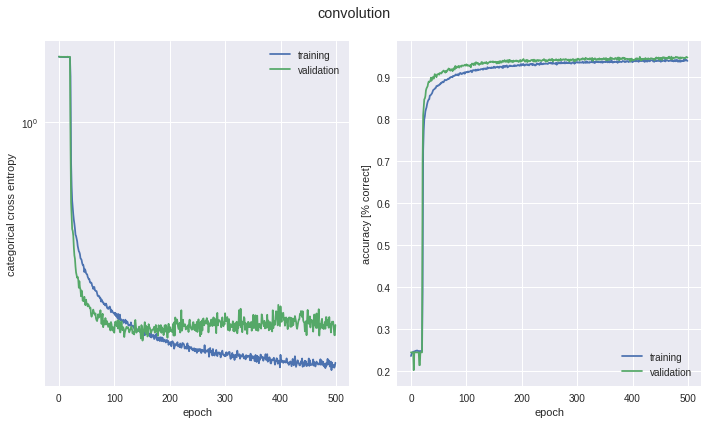

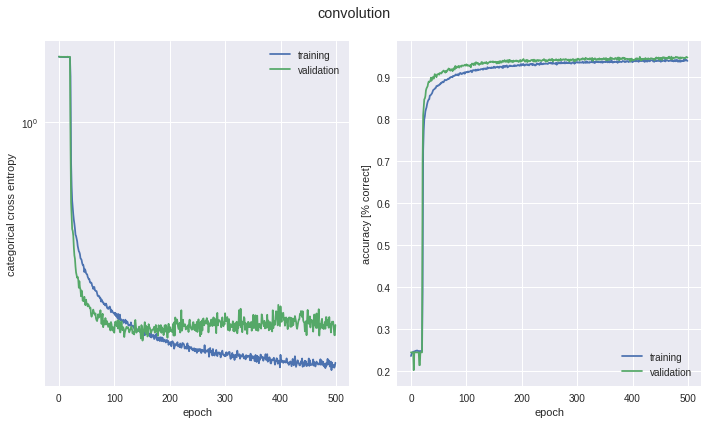

In [77]:

model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(16,16,1),name = "Conv1",activation = 'selu',padding = 'same',kernel_initializer = 'glorot_uniform'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv2",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv3",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv4",padding = 'same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv5",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv6",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(x_train_r, y_train, batch_size=128, epochs= 500, verbose=1, validation_data=(x_test_r, y_test))
plot_history(history, 'convolution')

In [0]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(16,16,1),name = "Conv1",activation = 'selu',padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv2",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv3",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv4",padding = 'same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv5",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv6",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
history = model.fit(x_train_r, y_train, batch_size=128, epochs= 90, verbose=1)

Epoch 1/90
34159/34159 [==============================] - 10s 289us/step - loss: 1.6029 - acc: 0.2397
Epoch 2/90
34159/34159 [==============================] - 5s 150us/step - loss: 1.6009 - acc: 0.2386
Epoch 3/90
34159/34159 [==============================] - 5s 152us/step - loss: 1.6002 - acc: 0.2439
Epoch 4/90
34159/34159 [==============================] - 5s 149us/step - loss: 1.5998 - acc: 0.2438
Epoch 5/90
 8192/34159 [======>.......................] - ETA: 3s - loss: 1.5957 - acc: 0.250734159/34159 [==============================] - 5s 150us/step - loss: 1.5990 - acc: 0.2447
Epoch 6/90
34159/34159 [==============================] - 5s 149us/step - loss: 1.5988 - acc: 0.2468
Epoch 7/90
34159/34159 [==============================] - 5s 149us/step - loss: 1.5985 - acc: 0.2475
Epoch 8/90
34159/34159 [==============================] - 5s 150us/step - loss: 1.5987 - acc: 0.2464
Epoch 9/90
13184/34159 [==========>...................] - ETA: 3s - loss: 1.5966 - acc: 0.251434159/34159 [=

13184/34159 [==========>...................] - ETA: 3s - loss: 0.3041 - acc: 0.893134159/34159 [==============================] - 5s 150us/step - loss: 0.3062 - acc: 0.8923
Epoch 70/90
34159/34159 [==============================] - 5s 149us/step - loss: 0.3071 - acc: 0.8928
Epoch 71/90
34159/34159 [==============================] - 5s 149us/step - loss: 0.3064 - acc: 0.8927
Epoch 72/90
34159/34159 [==============================] - 5s 149us/step - loss: 0.3076 - acc: 0.8932
Epoch 73/90
13568/34159 [==========>...................] - ETA: 3s - loss: 0.2930 - acc: 0.895634159/34159 [==============================] - 5s 151us/step - loss: 0.3008 - acc: 0.8953
Epoch 74/90
34159/34159 [==============================] - 5s 148us/step - loss: 0.2952 - acc: 0.8969
Epoch 75/90
34159/34159 [==============================] - 5s 149us/step - loss: 0.2934 - acc: 0.8989
Epoch 76/90
34159/34159 [==============================] - 5s 148us/step - loss: 0.2931 - acc: 0.8971
Epoch 77/90
13568/34159 [=====

In [68]:
model.evaluate(x_test_r, y_test, batch_size=128, verbose=1)

11785/11785 [==============================] - 3s 221us/step


[0.23421720970259235, 0.923292320746712]

In [41]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(16,16,1),name = "Conv1",activation = 'selu',padding = 'same',kernel_initializer = 'glorot_uniform'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv2",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv3",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv4",padding = 'same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv5",padding = 'same',kernel_initializer = 'glorot_uniform'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv6",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv7",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(x_train_r, y_train, batch_size=256, epochs= 100, verbose=1, validation_data=(x_test_r, y_test))
plot_history(history, 'convolution')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 16, 16, 32)        160       
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 16, 32)        4128      
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 8, 8, 32)          4128      
_________________________________________________________________
Conv4 (Conv2D)               (None, 8, 8, 32)          4128      
_________________________________________________________________
dropout_14 (Dropout)         (None, 8, 8, 32)          0         
__________

KeyboardInterrupt: 

In [22]:
data_train_32 = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test_32 = scipy.io.loadmat('housenumbers/test_32x32.mat')
x_train_32 = data_train_32['X']
y_train_32 = data_train_32['y']
x_test_32 = data_test_32['X']
y_test_32 = data_test_32['y']

In [31]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(16,16,1),name = "Conv1",activation = 'selu',padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv2",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv3",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv4",padding = 'same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv5",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv6",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv7",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(x_train_r, y_train, batch_size=256, epochs= 100, verbose=1, validation_data=(x_test_r, y_test))
plot_history(history, 'convolution')

(73257, 3, 32, 32)
(32, 32, 3, 73257)


ValueError: cannot reshape array of size 225045504 into shape (32,32,32,3)

In [9]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=input_shape,name = "Conv1",activation = 'selu',padding = 'same',kernel_initializer = 'glorot_uniform'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv2",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv3",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv4",padding = 'same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv5",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv6",padding = 'same'))
model.add(Conv2D(32, (2, 2), activation = 'selu',name = "Conv7",padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(x_train_32, y_train_32, batch_size=128, epochs= 50, verbose=1, validation_data=(x_test_32, y_test_32))
plot_history(history, 'convolution')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 32, 32, 32)        416       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 32)        4128      
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 32)        4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
__________

ValueError: Error when checking input: expected Conv1_input to have shape (32, 32, 3) but got array with shape (32, 3, 73257)